# Analyzing UTA's (Utah Transit Authority's) Bus Punctuality

UTA is Utah's largest public metropolitan transportation service. Affordable for citizens, it provides transportation throughout the Wasatch Front through various bus lines, trolley lines, and trains. Everyday, Utah commuters rely on UTA's services to commute across the state, to and from work, and to go where they please. Transportation is arguably the most important public service that can be offerred in a large metropolitan area, so naturally people rely on it for their day to day activities. Since people rely so heavily upon it, it needs to be punctual. Most people cannot chance being late from work, missing an exam at university, or possibly not going anywhere at all in the event of a missing bus.

With that in mind, I seek to answer this question: Can we predict the deviation of UTA's actual bus stop times compared to their scheduled stop times based on time of day?

This question is important because it will help commuters ensure they plan accordingly so they don't miss their busses and in turn miss important events. Additionally, this information can help improve public transportation by applying for more government funding to improve transportation infrastructure. UTA will also be able to see exactly where their variance has the highest deviations to see exactly where they are failing their commuters. UTA reducing varaince in their stop times will help build trust in their service. When people can rely on transportation, ridership will increase and thus lead to less cars on the road. Getting actual stop arrival time variance down will benefit everyone, even those who choose to drive.

My hypothesis is that UTA bus times vary largely, and to ensure you catch your buss it is not enough to arrive at the stop at the scheduled time. You must arrive early and stay after your scheduled time, else you chance missing the bus you intended to catch.

One potential solution to this problem could be that, if in my anlysis, it is shown such that actual stop arrival times have a peak variance UTA could introduce a dynamic route schedule wherein more busses are introduced to a route at specific times to reduce the variance at that time of day.

# Data Collection

To see all the moving parts that could not be hosted with the limitations of a hosted python service (such as Google Colab) please view my GitHub repository here: https://github.com/maxdotr/UTA-Punctuality-Analysis

UTA does not store their busses real-time location. Although they do have an API, found at https://webapi.rideuta.com/ with documentation at https://developer.rideuta.com/DataInstructions.aspx, that provides real time coordinates of their busses, to track this for long periods of time costs alot of memory and maintenance. Due to this issue, I will have to personally store the locations of busses after receiving data from UTA's tracking api. I did this over a twenty day period, April 11th, 2024 - April 22nd, 2024. The following script requests the location data for every bus on the routes specified once a minute from 6:00AM to 9:00PM. To host this script, I used PythonAnywhere. PythonAnywhere is a remote script hosting service which offers some really neat tools including "Always On" tasks, in which in the case of a crash, the task is immediately restarted. This service is why my script was able to consistently collect data over this 20 day period, ensuring the integrity of the data. Additionally, I used Python's scheduling library to run the script on a timer so as to not overwhelm UTA's API.

It is worth noting that this API is not a streaming API despite whatever the documentation says. In reality, at a certain time, UTA updated their API services such that the documentation doesn't mean much. Their developer tools are so outdated, they are hardly any use. In reality, the API is now a REST API. Once you request information from the servers, the busses send their location. To refresh this data, you must ping the API again.

(The script is commented out so the reader of this notebook does not accidentally run an always-on script)

In [42]:
'''
# DO NOT UNCOMMENT - THIS SCRIPT RUNS INDEFINITELY

import requests
import schedule
from datetime import datetime
from datetime import time
import pytz
import csv
import os
import time

# Filename and field names setup
filename = "bustimes.csv"
fields = ['vehicleID', 'routeNum', 'destination', 'latitude', 'longitude', 'bearing', 'weekday', 'date', 'time']
headersWritten = False

# Open the file once, write the header, and then append data rows
# Check and write headers if necessary
def writeHeadersIfNeeded():
    # Check if file exists and has content; only write headers if it's new or empty
    if not os.path.isfile(filename) or os.stat(filename).st_size == 0:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fields)
            writer.writeheader()

# Get routes that pass through downtown Salt Lake and University, not counting limited routes
routes = [1, 17, 2, 200, 205, 209, 21, 213, 220, 223, 4, 455, 470, 509, 9]

# Track the buses and log their times
def trackRoutes():
    if shouldTrack():
        for route in routes:

            # Fetching data from the API
            requestURL = f"https://webapi.rideuta.com/api/VehicleLocation/{route}"
            request = requests.get(requestURL)
            requestJSON = request.json()

            # Append data to the CSV file without overwriting it
            with open(filename, 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fields)
                for itemJSON in requestJSON:
                    MTC = pytz.timezone('America/Denver')
                    dateTimeMTC = datetime.now(MTC)

                    bus_data = {
                        'vehicleID': itemJSON['vehicleId'],
                        'routeNum': itemJSON['routeNum'],
                        'destination': itemJSON['destination'],
                        'latitude': itemJSON['location']['latitude'],
                        'longitude': itemJSON['location']['longitude'],
                        'bearing': itemJSON['bearing'],
                        'weekday': dateTimeMTC.weekday(),
                        'date': dateTimeMTC.strftime('%x'),
                        'time': dateTimeMTC.strftime('%X')
                    }
                    writer.writerow(bus_data)

def shouldTrack():
    MTC = pytz.timezone('America/Denver')
    now_time = datetime.now(MTC).time()
    start_time = datetime.strptime('06:00:00', '%H:%M:%S').time()
    end_time = datetime.strptime('21:00:00', '%H:%M:%S').time()
    return start_time <= now_time <= end_time


schedule.every(1).minutes.do(trackRoutes)
# Main loop
if __name__ == "__main__":
    writeHeadersIfNeeded()  # Ensure headers are written if needed on start/restart
    while True:
        schedule.run_pending()
        time.sleep(5)  # Sleep for a short time to prevent a busy-wait loop

'''

'\n# DO NOT UNCOMMENT - THIS SCRIPT RUNS INDEFINITELY\n\nimport requests\nimport schedule\nfrom datetime import datetime\nfrom datetime import time\nimport pytz\nimport csv\nimport os\nimport time\n\n# Filename and field names setup\nfilename = "bustimes.csv"\nfields = [\'vehicleID\', \'routeNum\', \'destination\', \'latitude\', \'longitude\', \'bearing\', \'weekday\', \'date\', \'time\']\nheadersWritten = False\n\n# Open the file once, write the header, and then append data rows\n# Check and write headers if necessary\ndef writeHeadersIfNeeded():\n    # Check if file exists and has content; only write headers if it\'s new or empty\n    if not os.path.isfile(filename) or os.stat(filename).st_size == 0:\n        with open(filename, \'w\', newline=\'\') as csvfile:\n            writer = csv.DictWriter(csvfile, fieldnames=fields)\n            writer.writeheader()\n\n# Get routes that pass through downtown Salt Lake and University, not counting limited routes\nroutes = [1, 17, 2, 200, 205,

After running this script for 20 days, I had over 6 million points of data. This data was raw location data taken every minute and told me nothing about when the bus actually arrived at a stop. To figure that out, I had to develop an algorithm that would match the closest location point, in a scheduled interval, on a scheduled route, on a specific day. Mind boggling I know, so I will now provide a brief breakdwon of what the algorithm does step by step:

- First we fetch static location data from UTA's public GTFS data set. This is the data set that hosts static information like routes, stops, scheduled times, etc, that UTA gives to transit providers like Google and Apple maps.
- Clean the data to be in usable formats, like making scheduled stop times as valid date time objects to be used in comparisons.
- For each bus route, we must then merge relevant datasets to consolidate route, stop, and trip information.
- For each scheduled stop time in the dataset we just created, we then need to calculate the interval in which to filter our actual location data to check for distances in this interval. (Ex: Scheduled time is for 9:00AM at stop X for route 9 going towards Poplar Grove on April 12th, we should only check our actual locations if they are for route 9 going towards Poplar Grove and were recorded betweem 8:45AM and and 9:15AM on April 12th)
- For each filtered bus location point in that interval, we must calculate the distance from that bus to the stop we are looking at. The closest distance is
\+\\-30 seconds to the actual time the bus passed/arrived at the stop. (Busses don't always stop if no one is there)
- Calculate the time difference based on the match we just found
- Add this to a dataframe for logging purposes.

This algorithm is not optimized for efficiency, but it IS very accurate. It is so time inefficient, logging operations substantially increased the runtime to the point where I had to develop an asynchronus multithreaded logging solution just so it would run on a small dataset in a timely manner for testing. (Seen on my GitHub) To process the entire 6 million points, it took about 18 hours and used 8GB of RAM. The algorithm is commented out so it is not accidentally ran in the notebook.

In [43]:
'''

#DO NOT RUN - HOUR LONG RUNTIME WITH LARGE EXPENDITURE TO COMPUTER RESOURCES

import logging
from logging.handlers import QueueHandler, QueueListener
from EvictQueue import EvictQueue
import pandas as pd
from geopy.distance import geodesic
from datetime import datetime, timedelta, time
import numpy as np
import csv
import os

# Setup logger root
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)  # Set the minimum log level

# Timestamp for the filename
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"logs_{current_time}.log"  # e.g., logs_2023-01-01_12-00-00.log

# Ensure a directory exists for the logs
if not os.path.exists('logs'):
    os.makedirs('logs')

# Full path for the log file
full_log_path = os.path.join('logs', log_filename)

# Create handlers for console and file output
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.INFO)
fileHandler = logging.FileHandler(full_log_path)
fileHandler.setLevel(logging.INFO)

# Common formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
consoleHandler.setFormatter(formatter)
fileHandler.setFormatter(formatter)

# Create an EvictQueue and QueueHandler
log_que = EvictQueue(1000)
queue_handler = QueueHandler(log_que)

# Set up the QueueListener with both handlers
queue_listener = QueueListener(log_que, consoleHandler, fileHandler)
queue_listener.start()

# Clear existing handlers and add only the QueueHandler
rootLogger.handlers = []
rootLogger.addHandler(queue_handler)

# Setup done
logging.info("Logger setup complete with file logging")


# Load data
df_routes = pd.read_csv('https://raw.githubusercontent.com/maxdotr/UTA-Punctuality-Analysis/main/routes.csv')
df_stop_times = pd.read_csv('https://raw.githubusercontent.com/maxdotr/UTA-Punctuality-Analysis/main/stop_times.csv')
df_stops = pd.read_csv('https://raw.githubusercontent.com/maxdotr/UTA-Punctuality-Analysis/main/stops.csv')
df_trips = pd.read_csv('https://raw.githubusercontent.com/maxdotr/UTA-Punctuality-Analysis/main/trips.csv')
bus_locations_df = pd.read_csv('https://raw.githubusercontent.com/maxdotr/UTA-Punctuality-Analysis/main/bustimes04242024.csv', low_memory=False)

# Adjust the time handling function - data between df's is different
def clean_and_convert_time(time_str):
    time_str = time_str.strip().replace('24:', '00:')
    dt = pd.to_datetime(time_str, format='%H:%M:%S', errors='coerce')
    if pd.isna(dt):
        return None  # Skip or handle invalid times
    return dt.time()


# Apply time cleaning function
logging.info("Start cleaning times")
bus_locations_df['time'] = bus_locations_df['time'].apply(clean_and_convert_time)
df_stop_times['arrival_time'] = df_stop_times['arrival_time'].apply(clean_and_convert_time)
logging.info("Stop cleanign times")

logging.info("Starting merges")
# Merge operations
df_trips_routes = pd.merge(df_trips, df_routes[['route_id', 'route_short_name']], on='route_id', how='left')
logging.info(df_trips_routes)
df_trip_route_stoptimes = pd.merge(df_trips_routes, df_stop_times[['trip_id', 'arrival_time', 'stop_id']], on='trip_id', how='left')
logging.info(df_trip_route_stoptimes)
final_df = pd.merge(df_trip_route_stoptimes, df_stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id', how='left')
logging.info(final_df)

# Select relevant columns and sort
expected_route_punctuality_df = final_df[['stop_id', 'route_short_name', 'stop_name', 'trip_headsign', 'stop_lat', 'stop_lon', 'arrival_time']]
expected_route_punctuality_df = expected_route_punctuality_df.sort_values(by=['stop_id', 'arrival_time'])
logging.info(expected_route_punctuality_df)
logging.info("Merges end")

# Calculates distance based on coords
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Find closest approach
def find_closest_approach(bus_df, stop):
    bus_df['distance_to_stop'] = bus_df.apply(
        lambda row: calculate_distance(row['latitude'], row['longitude'], stop['stop_lat'], stop['stop_lon']), axis=1)
    min_distance_idx = bus_df['distance_to_stop'].idxmin()
    return bus_df.loc[min_distance_idx]

def parse_date(date_str):
    try:
        # Adjust format to match 'mm/dd/yy'
        return datetime.strptime(date_str, "%m/%d/%y").date()
    except ValueError:
        # Log an error if the date format is incorrect
        logging.error("Date format error for date: %s", date_str)
        return None

# Calculates interval for calculations
def calculate_operational_intervals(scheduled_times):
    arbitrary_date = datetime(2000, 1, 1)
    datetime_list = [datetime.combine(arbitrary_date, t) for t in scheduled_times if isinstance(t, time)]

    # Assuming operational hours are from 6 AM to 10 PM
    operational_start = datetime.combine(arbitrary_date, time(6, 0))
    operational_end = datetime.combine(arbitrary_date, time(21, 0))

    # Filter datetimes to include only those within operational hours
    operational_times = [dt for dt in datetime_list if operational_start <= dt <= operational_end]

    # Calculate intervals in minutes between consecutive times
    intervals = [(operational_times[i] - operational_times[i-1]).total_seconds() / 60 for i in range(1, len(operational_times))]
    logging.debug("Stop interval: %s", np.median(intervals))
    if intervals:
        if(np.median(intervals) >= 30.0):
            return 30.0
        else:
            return 15.0
    else:
        return 15

def match_times(bus_df, stop_info, scheduled_times):
    matched_times = []
    unique_dates = bus_df['date'].dropna().unique()

    logging.debug("Unique dates found in bus locations data: %s", unique_dates)

    average_interval = calculate_operational_intervals(scheduled_times)
    half_interval = average_interval / 2

    for unique_date in unique_dates:
        current_date = parse_date(unique_date)
        if current_date is None:
            continue  # Skip processing if date parsing failed

        daily_bus_df = bus_df[bus_df['date'] == unique_date]
        used_indices = set()  # Set to track indices of matched bus entries

        logging.debug("Processing matches for date: %s", current_date)

        # Remove any NaT values and sort scheduled_times in ascending order
        valid_times = [t for t in scheduled_times if t is not pd.NaT]
        scheduled_times_sorted = sorted(valid_times)

        for scheduled_time in scheduled_times_sorted:
            if isinstance(scheduled_time, time):
                full_datetime = datetime.combine(current_date, scheduled_time)
                time_window_start = (full_datetime - timedelta(minutes=half_interval))
                time_window_end = (full_datetime + timedelta(minutes=half_interval))

                # Adjusting time window to not start before 6 AM or end after 9 PM
                earliest_start = datetime.combine(current_date, time(6, 0))
                latest_end = datetime.combine(current_date, time(21, 0))

                if time_window_start < earliest_start:
                    time_window_start = earliest_start
                if time_window_end > latest_end:
                    time_window_end = latest_end

                # Convert back to time objects
                time_window_start = time_window_start.time()
                time_window_end = time_window_end.time()

                temp_df = daily_bus_df[
                    (daily_bus_df['time'] >= time_window_start) &
                    (daily_bus_df['time'] <= time_window_end) &
                    (daily_bus_df['routeNum'] == stop_info['route_short_name']) &
                    (~daily_bus_df.index.isin(used_indices))
                ].copy()

                if not temp_df.empty:
                    closest_bus = find_closest_approach(temp_df, stop_info)
                    matched_time = {
                        'vehicle_id': closest_bus['vehicleID'],
                        'stop_id': stop_info['stop_id'],
                        'stop_name': stop_info['stop_name'],
                        'route': closest_bus['routeNum'],
                        'destination': closest_bus['destination'],
                        'scheduled_arrival_time': scheduled_time,
                        'actual_arrival_time': closest_bus['time'],
                        'distance_to_stop': closest_bus['distance_to_stop'],
                        'match_date': current_date
                    }
                    writer.writerow(matched_time)
                    matched_times.append(matched_time)
                    used_indices.add(closest_bus.name)

                    logging.info("Match Found! %s", matched_time)
                else:
                    logging.debug("No buses found within the time window for scheduled time: %s on route %s for date %s",
                                 scheduled_time, stop_info['route_short_name'], current_date)
            else:
                logging.info("Invalid time object encountered: %s", scheduled_time)

    return matched_times

def setup_csv_writer():
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    filename = f"match_results_{timestamp}.csv"
    file = open(filename, 'w', newline='', encoding='utf-8')
    writer = csv.DictWriter(file, fieldnames=[
        'vehicle_id', 'stop_id', 'stop_name', 'route', 'destination',
        'scheduled_arrival_time', 'actual_arrival_time', 'distance_to_stop', 'match_date'
    ])
    writer.writeheader()
    return file, writer

def close_csv_file(file):
    file.close()





# Convert times in expected_route_punctuality_df
expected_route_punctuality_df['arrival_time'] = pd.to_datetime(expected_route_punctuality_df['arrival_time'], format='%H:%M:%S').dt.time

# Prepare bus locations data
bus_locations_df['routeNum'] = bus_locations_df['routeNum'].astype(str)
bus_locations_df.sort_values(['routeNum', 'destination', 'time'], inplace=True)

# Group by stop to handle multiple arrivals and perform the matching
all_results = []
grouped = expected_route_punctuality_df.groupby(['stop_id', 'route_short_name', 'trip_headsign'])

logging.info("Expected route punctuality:  %s", expected_route_punctuality_df)

# Group by stop to handle multiple arrivals and perform the matching
all_results = []
grouped = expected_route_punctuality_df.groupby(['stop_id', 'route_short_name', 'trip_headsign'])

file, writer = setup_csv_writer()

for name, group in grouped:
    stop_info = {
        'stop_id': name[0],
        'stop_name': group['stop_name'].iloc[0],
        'route_short_name': name[1],
        'trip_headsign': name[2],
        'stop_lat': group.iloc[0]['stop_lat'],
        'stop_lon': group.iloc[0]['stop_lon']
    }
    # Convert scheduled times to a set and back to list to remove duplicates
    scheduled_times = list(set(group['arrival_time'].tolist()))

    results = match_times(bus_locations_df, stop_info, scheduled_times)
    all_results.extend(results)

close_csv_file(file)

# Convert all results to a DataFrame for analysis
final_results_df = pd.DataFrame(all_results)


# Check results
print(final_results_df.head())


# Assuming final_results_df['actual_arrival_time'] and final_results_df['scheduled_arrival_time'] are in datetime.time format
def compute_time_difference(row):
    # Choose an arbitrary date for converting time to datetime
    arbitrary_date = datetime(2000, 1, 1)  # Y2K why not?!
    # Combine time with arbitrary date
    actual_datetime = datetime.combine(arbitrary_date, row['actual_arrival_time'])
    scheduled_datetime = datetime.combine(arbitrary_date, row['scheduled_arrival_time'])

    # Calculate time difference
    time_difference = actual_datetime - scheduled_datetime
    return time_difference.total_seconds() / 60

# Apply this function to calculate time differences
final_results_df['time_difference'] = final_results_df.apply(compute_time_difference, axis=1)

# Print discrepancies over a threshold (e.g., over 5 minutes)
print(final_results_df)

# Generate timestamped file name
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_name = f"final_results_{timestamp}.csv"

# Save to CSV
final_results_df.to_csv(file_name, index=False)
'''

'\n\n#DO NOT RUN - HOUR LONG RUNTIME WITH LARGE EXPENDITURE TO COMPUTER RESOURCES\n\nimport logging\nfrom logging.handlers import QueueHandler, QueueListener\nfrom EvictQueue import EvictQueue\nimport pandas as pd\nfrom geopy.distance import geodesic\nfrom datetime import datetime, timedelta, time\nimport numpy as np\nimport csv\nimport os\n\n# Setup logger root\nrootLogger = logging.getLogger()\nrootLogger.setLevel(logging.INFO)  # Set the minimum log level\n\n# Timestamp for the filename\ncurrent_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")\nlog_filename = f"logs_{current_time}.log"  # e.g., logs_2023-01-01_12-00-00.log\n\n# Ensure a directory exists for the logs\nif not os.path.exists(\'logs\'):\n    os.makedirs(\'logs\')\n\n# Full path for the log file\nfull_log_path = os.path.join(\'logs\', log_filename)\n\n# Create handlers for console and file output\nconsoleHandler = logging.StreamHandler()\nconsoleHandler.setLevel(logging.INFO)\nfileHandler = logging.FileHandler(full_lo

# Data limitations

Since I collected all the data myself, there were some limitations so as to not overwhelm UTA's API, my computer resources, my storage limitations, and the integrity of my scripts. They are as follows:

- Data was only collected for UTA bus routes that pass through either downtown Salt Lake City or the University of Utah.
- Data was only collected between 6AM and 9PM, even though some routes go later into the night and some start earlier.
- Data was only collected over a 20 day period, April 11th, 2024 - April 22nd, 2024.
- Some route's bus trackers sometimes go offline, which results in inaccurate location data. (Cleaned later)
- Bus routes were taken every minute so actual arrival time I calculated could be +/- 30 seconds. This would happen if the bus passed a stop between the minute interval.

```
# This is formatted as code
```



# Reading in the data

Now that we have a compiled data set, we can get to the meat of the analysis. I uploaded the data from the algorithm to GitHub, which is where we are reading from.

In [44]:
from datetime import datetime, timedelta, time, date
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sb
from patsy import dmatrix
import numpy as np

In [45]:
import pandas as pd

time_results_df = pd.read_csv("https://media.githubusercontent.com/media/maxdotr/UTA-Punctuality-Analysis/main/match_results_20240421-120247.csv", low_memory=False)
time_results_df.head()

vehicle_id  stop_id            stop_name  route               destination  \
0      15022     1022  University Hospital      1  Poplar Grove (Orange St)   
1      15022     1022  University Hospital      1  Poplar Grove (Orange St)   
2      18022     1022  University Hospital      1       University Hospital   
3      18022     1022  University Hospital      1  Poplar Grove (Orange St)   
4      13001     1022  University Hospital      1  Poplar Grove (Orange St)   

  scheduled_arrival_time actual_arrival_time  distance_to_stop  match_date  
0               06:05:00            06:00:00          1.741058  2024-04-12  
1               06:20:00            06:14:59          0.751588  2024-04-12  
2               06:35:00            06:42:01         94.568447  2024-04-12  
3               06:50:00            06:43:08          8.966128  2024-04-12  
4               07:05:00            06:58:54          8.966128  2024-04-12

# Check the packaging, looking at the top and bottom of data, and checking n's

Since I created this dataset, I am very familiar with what it looks like. I have time and time again de-bugged my algorithm so I am very sure the data is accurate and shaped well (except some things that will be cleaned later) but I will perform these steps for posterity's sake.

Packaging

In [46]:
time_results_df.shape

(862727, 9)

Top of the data:

In [47]:
time_results_df.head()

vehicle_id  stop_id            stop_name  route               destination  \
0      15022     1022  University Hospital      1  Poplar Grove (Orange St)   
1      15022     1022  University Hospital      1  Poplar Grove (Orange St)   
2      18022     1022  University Hospital      1       University Hospital   
3      18022     1022  University Hospital      1  Poplar Grove (Orange St)   
4      13001     1022  University Hospital      1  Poplar Grove (Orange St)   

  scheduled_arrival_time actual_arrival_time  distance_to_stop  match_date  
0               06:05:00            06:00:00          1.741058  2024-04-12  
1               06:20:00            06:14:59          0.751588  2024-04-12  
2               06:35:00            06:42:01         94.568447  2024-04-12  
3               06:50:00            06:43:08          8.966128  2024-04-12  
4               07:05:00            06:58:54          8.966128  2024-04-12

Bottom of the data:

In [48]:
time_results_df.tail()

vehicle_id  stop_id                    stop_name  route  \
862722      13008    18241  North Temple / Main St (EB)    470   
862723      17021    18241  North Temple / Main St (EB)    470   
862724      17003    18241  North Temple / Main St (EB)    470   
862725      17003    18241  North Temple / Main St (EB)    470   
862726      21018    18241  North Temple / Main St (EB)    470   

                    destination scheduled_arrival_time actual_arrival_time  \
862722                    Ogden               11:01:34            11:05:35   
862723  Downtown Salt Lake City               11:10:22            11:10:09   
862724                    Ogden               11:28:22            11:35:20   
862725                    Ogden               11:31:34            11:36:29   
862726  Downtown Salt Lake City               11:40:22            11:39:54   

        distance_to_stop  match_date  
862722        193.139511  2024-04-17  
862723        238.344726  2024-04-17  
862724        325.740231  2024-04-17  
862725        151.098123  2024-04-17  
862726        208.034976  2024-04-17

Checking the n's (Routes should only appear for routes I was tracking)

In [49]:
unique_routes = time_results_df['route'].unique()
print(unique_routes)

[  1   2 205 509 223 209 213   4 455  21  17   9 220 470 200]


Everything looks good!

# Cleaning the data

My algorithm is very accurate, but some of the merge operations with UTA's static data caused duplicates. These duplicates in the final dataset I made are caused by duplicate scheduled stop times in the dataset the algorithm was using to create it. They can be removed.

In [50]:
duplicate_rows = time_results_df[time_results_df.duplicated(subset=['stop_id', 'match_date', 'scheduled_arrival_time'], keep=False)]
print(duplicate_rows)

       vehicle_id  stop_id                       stop_name  route  \
0           15022     1022             University Hospital      1   
1           15022     1022             University Hospital      1   
2           18022     1022             University Hospital      1   
3           18022     1022             University Hospital      1   
4           13001     1022             University Hospital      1   
...           ...      ...                             ...    ...   
859231      23005    18195  Murray Central Station (Bay H)    200   
859232      23024    18195  Murray Central Station (Bay H)    200   
859233      23024    18195  Murray Central Station (Bay H)    200   
859234      23008    18195  Murray Central Station (Bay H)    200   
859235      21016    18195  Murray Central Station (Bay H)    200   

                                  destination scheduled_arrival_time  \
0                    Poplar Grove (Orange St)               06:05:00   
1                    Poplar

In [51]:
cleaned_times_df =  time_results_df.drop_duplicates(subset=['vehicle_id', 'stop_id', 'match_date', 'scheduled_arrival_time'], keep=False)

In [52]:
cleaned_times_df.head()

vehicle_id  stop_id            stop_name  route               destination  \
0        15022     1022  University Hospital      1  Poplar Grove (Orange St)   
57       15003     1022  University Hospital      1  Poplar Grove (Orange St)   
114      18002     1022  University Hospital      1  Poplar Grove (Orange St)   
163      15001     1022  University Hospital      1  Poplar Grove (Orange St)   
220      15007     1022  University Hospital      1  Poplar Grove (Orange St)   

    scheduled_arrival_time actual_arrival_time  distance_to_stop  match_date  
0                 06:05:00            06:00:00          1.741058  2024-04-12  
57                06:05:00            06:00:42       1212.131588  2024-04-19  
114               06:05:00            06:01:36          8.344103  2024-04-13  
163               06:05:00            06:00:13          9.102630  2024-04-11  
220               06:05:00            06:00:59        920.246821  2024-04-18

Some of the distances calculated are off because UTA's tracking API isn't always working correctly. If the algorithm matched a stop and the distance to the stop was greater than 100 meters, this is because a bus on that route or the route itself wasn't updating the API correctly. This is a known issue with the API so removing these entries can be done without worry.

In [53]:
cleaned_times_df = cleaned_times_df[cleaned_times_df['distance_to_stop'] <= 100]

In [54]:
cleaned_times_df.head()

vehicle_id  stop_id            stop_name  route               destination  \
0        15022     1022  University Hospital      1  Poplar Grove (Orange St)   
114      18002     1022  University Hospital      1  Poplar Grove (Orange St)   
163      15001     1022  University Hospital      1  Poplar Grove (Orange St)   
391      15009     1022  University Hospital      1  Poplar Grove (Orange St)   
534      13001     1022  University Hospital      1       University Hospital   

    scheduled_arrival_time actual_arrival_time  distance_to_stop  match_date  
0                 06:05:00            06:00:00          1.741058  2024-04-12  
114               06:05:00            06:01:36          8.344103  2024-04-13  
163               06:05:00            06:00:13          9.102630  2024-04-11  
391               06:05:00            06:00:41          9.369665  2024-04-17  
534               19:35:00            19:35:37         22.023627  2024-04-12

In [55]:
routes = [1, 17, 2, 200, 205, 209, 21, 213, 220, 223, 4, 455, 470, 509, 9]

Now, we want to add a column that displays the absolute time difference from the scheduled time to the actual arrival time. We are using absolute variance because 'lateness' or 'earlyness' is a matter of perspective. A bus that arrives 25 minutes after its scheduled time could be late to the people originally waiting for it while being early for the people planning to get on at the next scheduled arrival time.

In [56]:
def compute_time_difference(row):
    arbitrary_date = datetime(2000, 1, 1)
    actual_datetime = datetime.combine(arbitrary_date, row['actual_arrival_time'])
    scheduled_datetime = datetime.combine(arbitrary_date, row['scheduled_arrival_time'])
    time_difference = actual_datetime - scheduled_datetime
    return abs(time_difference.total_seconds() / 60)

In [57]:
def clean_and_convert_time(time_str):
    time_str = time_str.strip().replace('24:', '00:')
    dt = pd.to_datetime(time_str, format='%H:%M:%S', errors='coerce')
    if pd.isna(dt):
        return None
    return dt.time()

In [58]:
cleaned_times_df['scheduled_arrival_time'] = cleaned_times_df['scheduled_arrival_time'].apply(clean_and_convert_time)
cleaned_times_df['actual_arrival_time'] = cleaned_times_df['actual_arrival_time'].apply(clean_and_convert_time)

In [59]:
cleaned_times_df['time_difference'] = cleaned_times_df.apply(compute_time_difference, axis=1)

In [60]:
cleaned_times_df.head()

vehicle_id  stop_id            stop_name  route               destination  \
0        15022     1022  University Hospital      1  Poplar Grove (Orange St)   
114      18002     1022  University Hospital      1  Poplar Grove (Orange St)   
163      15001     1022  University Hospital      1  Poplar Grove (Orange St)   
391      15009     1022  University Hospital      1  Poplar Grove (Orange St)   
534      13001     1022  University Hospital      1       University Hospital   

    scheduled_arrival_time actual_arrival_time  distance_to_stop  match_date  \
0                 06:05:00            06:00:00          1.741058  2024-04-12   
114               06:05:00            06:01:36          8.344103  2024-04-13   
163               06:05:00            06:00:13          9.102630  2024-04-11   
391               06:05:00            06:00:41          9.369665  2024-04-17   
534               19:35:00            19:35:37         22.023627  2024-04-12   

     time_difference  
0           5.000000  
114         3.400000  
163         4.783333  
391         4.316667  
534         0.616667

# Validating Against External Knowledge

On 04/16 I took these videos with the purpose of proving the accuracy of my algorithm and data collection methods. As you can I took the photo at the busses location at 4:32, screenshotted the tracker information at 4:33, and boarded at 4:35.

I then searched my match times for this bus, and low and behold the info matches!

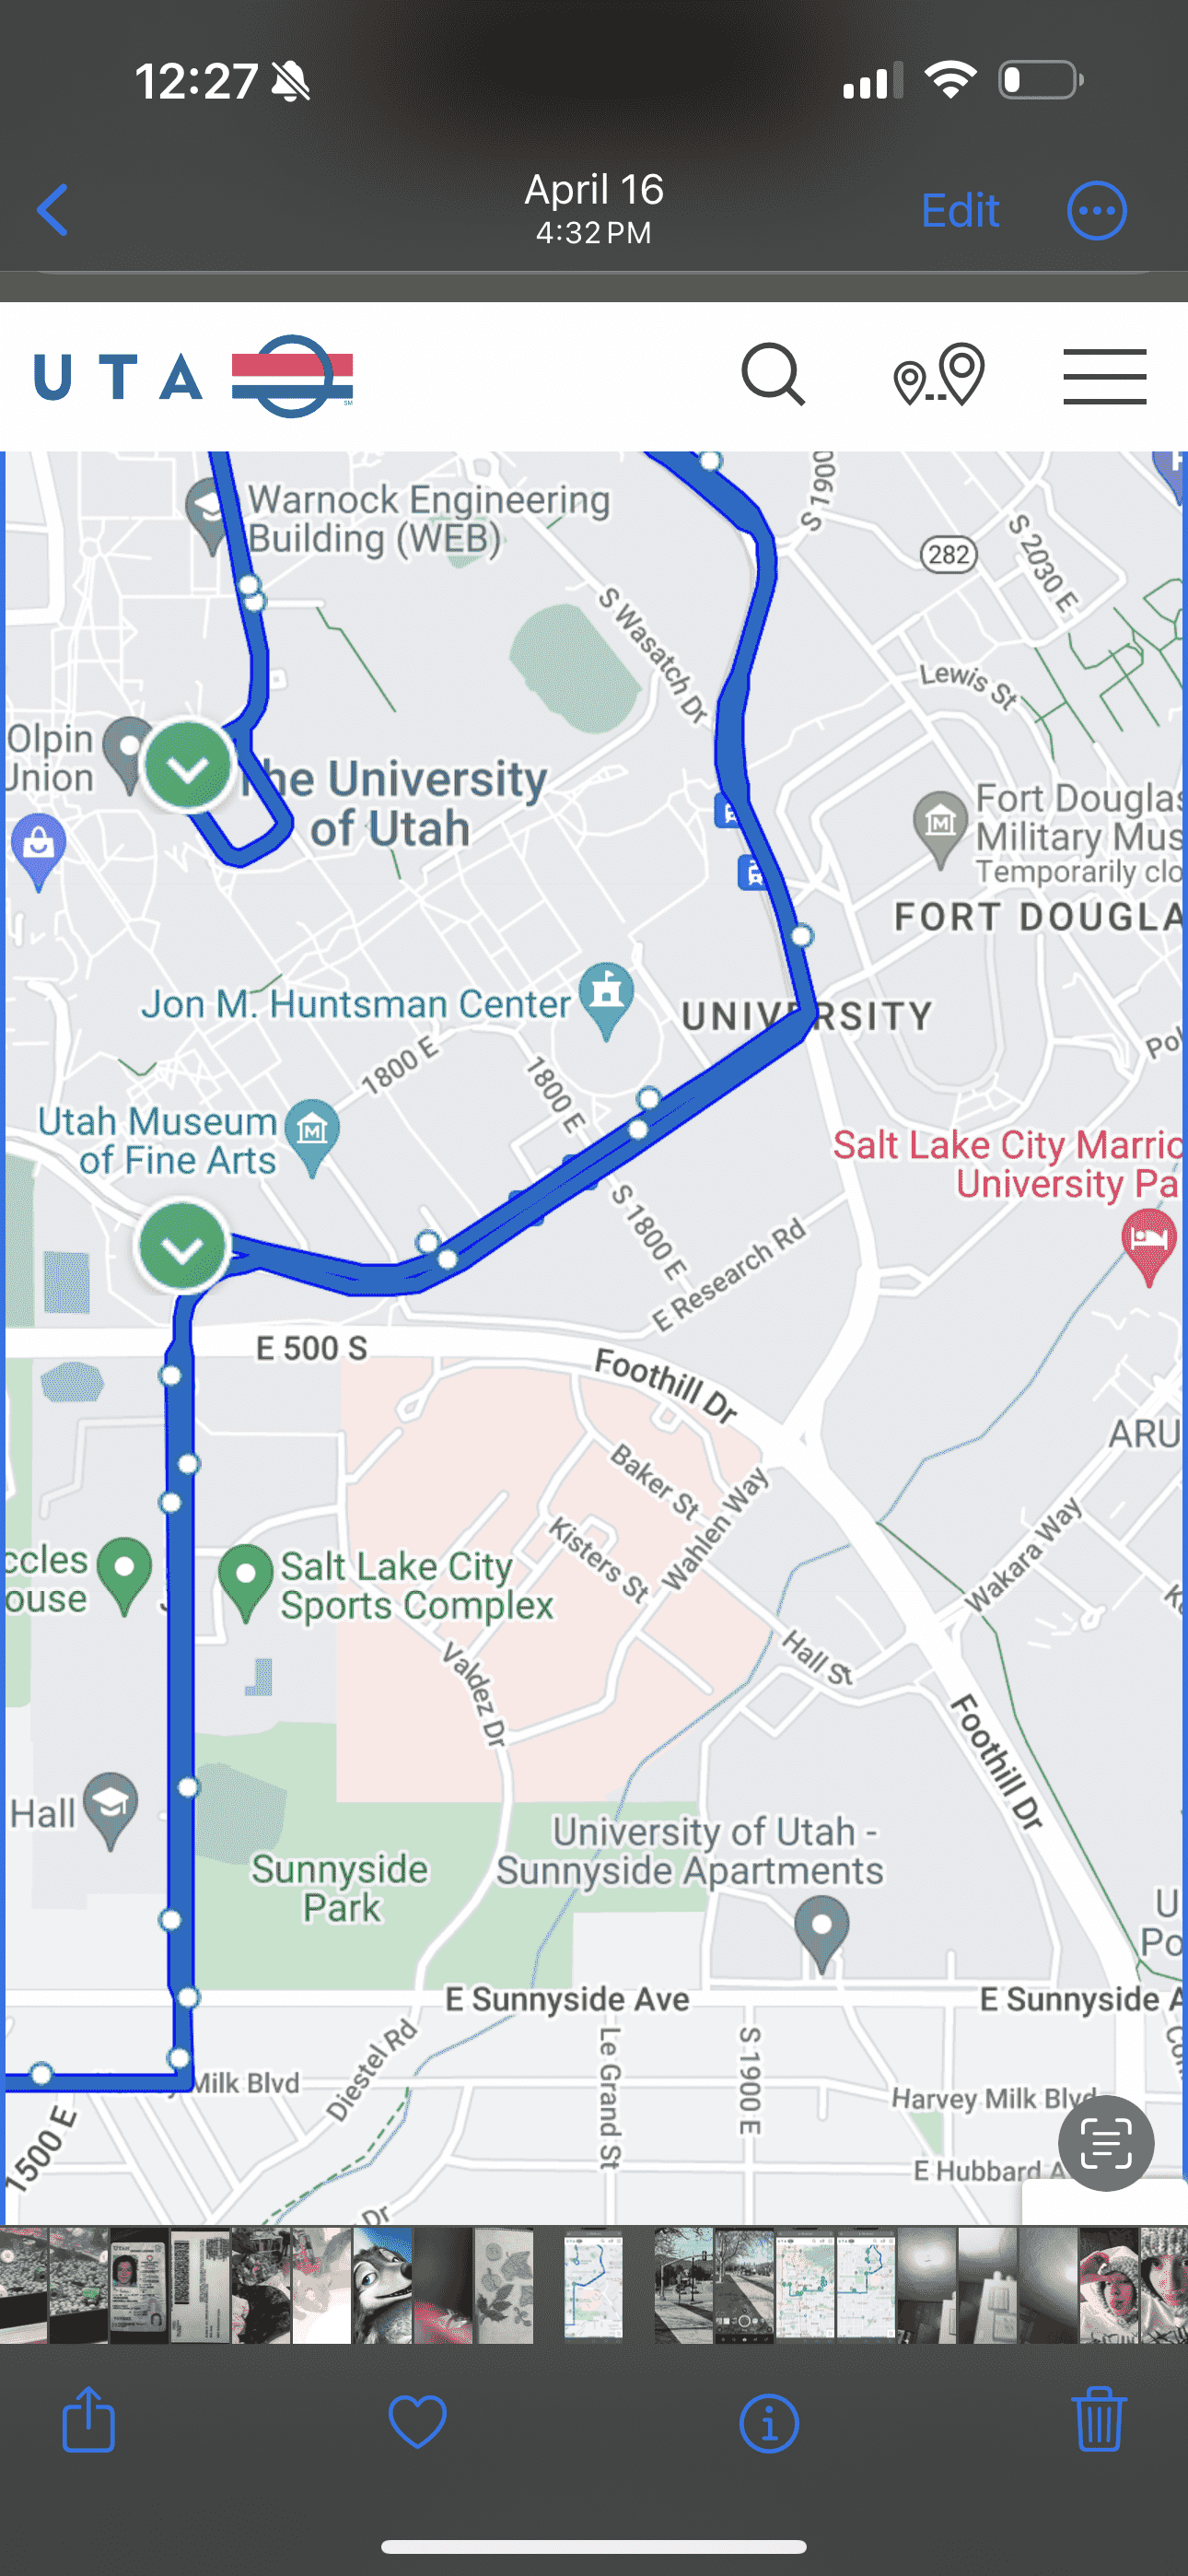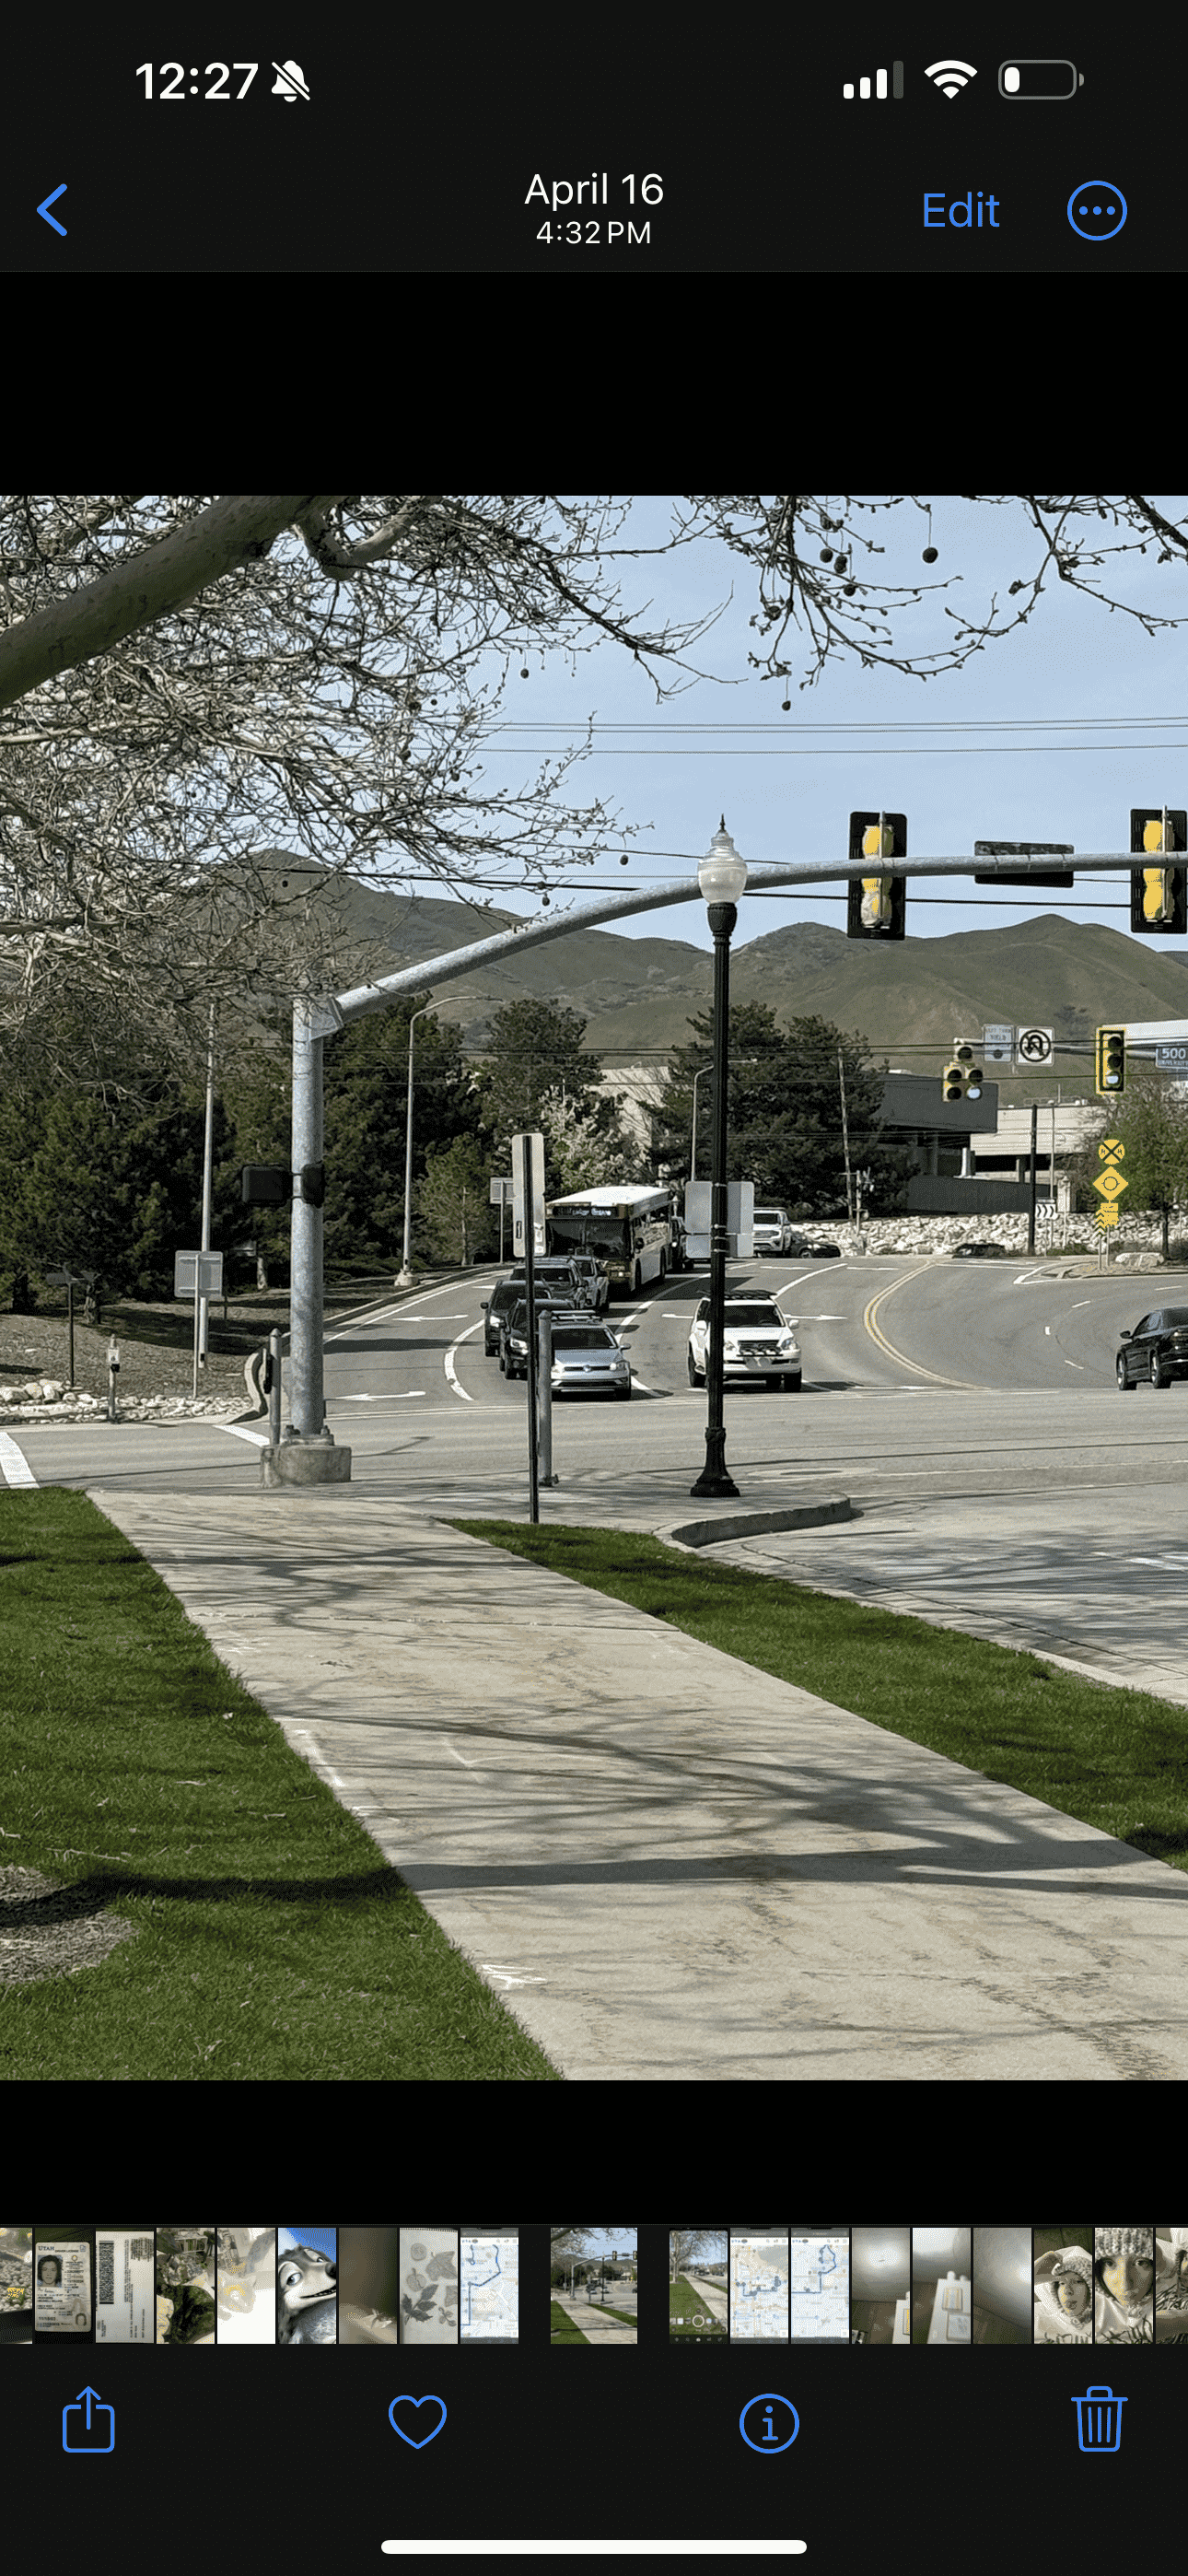

In [61]:
filtered_df = cleaned_times_df[
    (cleaned_times_df['match_date'] == '2024-04-16') &
    (cleaned_times_df['scheduled_arrival_time'].apply(lambda x: x.hour == 16 and x.minute == 34)) &
    (cleaned_times_df['route'] == 9) &
    (cleaned_times_df['destination'] == 'Poplar Grove (Orange St)')
]

filtered_df.head()

vehicle_id  stop_id                           stop_name  route  \
834415      23022    17727  Guardsman Way / Sunnyside Ave (SB)      9   

                     destination scheduled_arrival_time actual_arrival_time  \
834415  Poplar Grove (Orange St)               16:34:10            16:35:21   

        distance_to_stop  match_date  time_difference  
834415         45.447899  2024-04-16         1.183333

# Early visualizations

Now that we know our data is correct, I want to get a quick idea where my hypothesis is at. To do this, I will create a bar chart for the average for variance for each stop on each route I tracked. Bar charts are great for comparing categorical dependent variables to independent dynamic variables. Looking at the data, it does seem there are trends in variance!

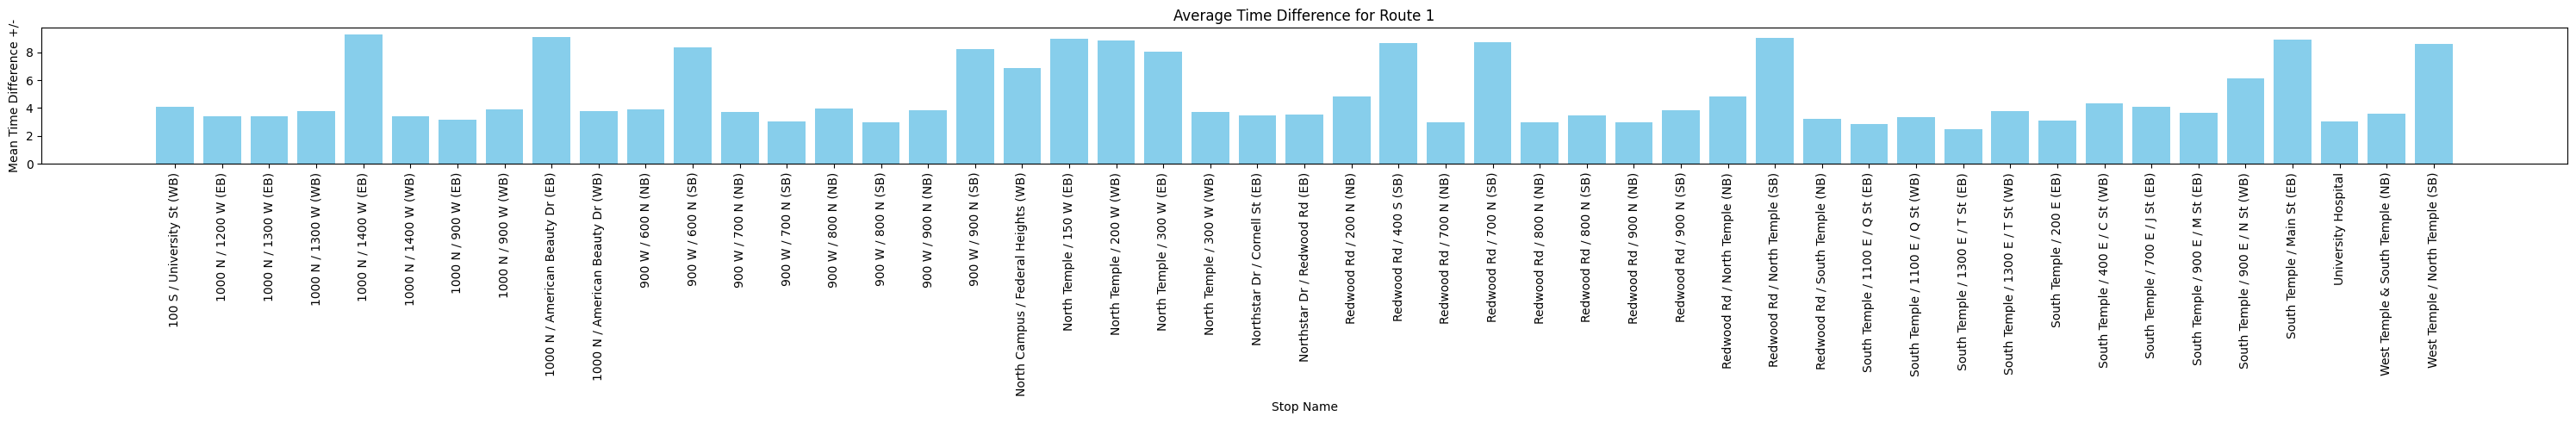

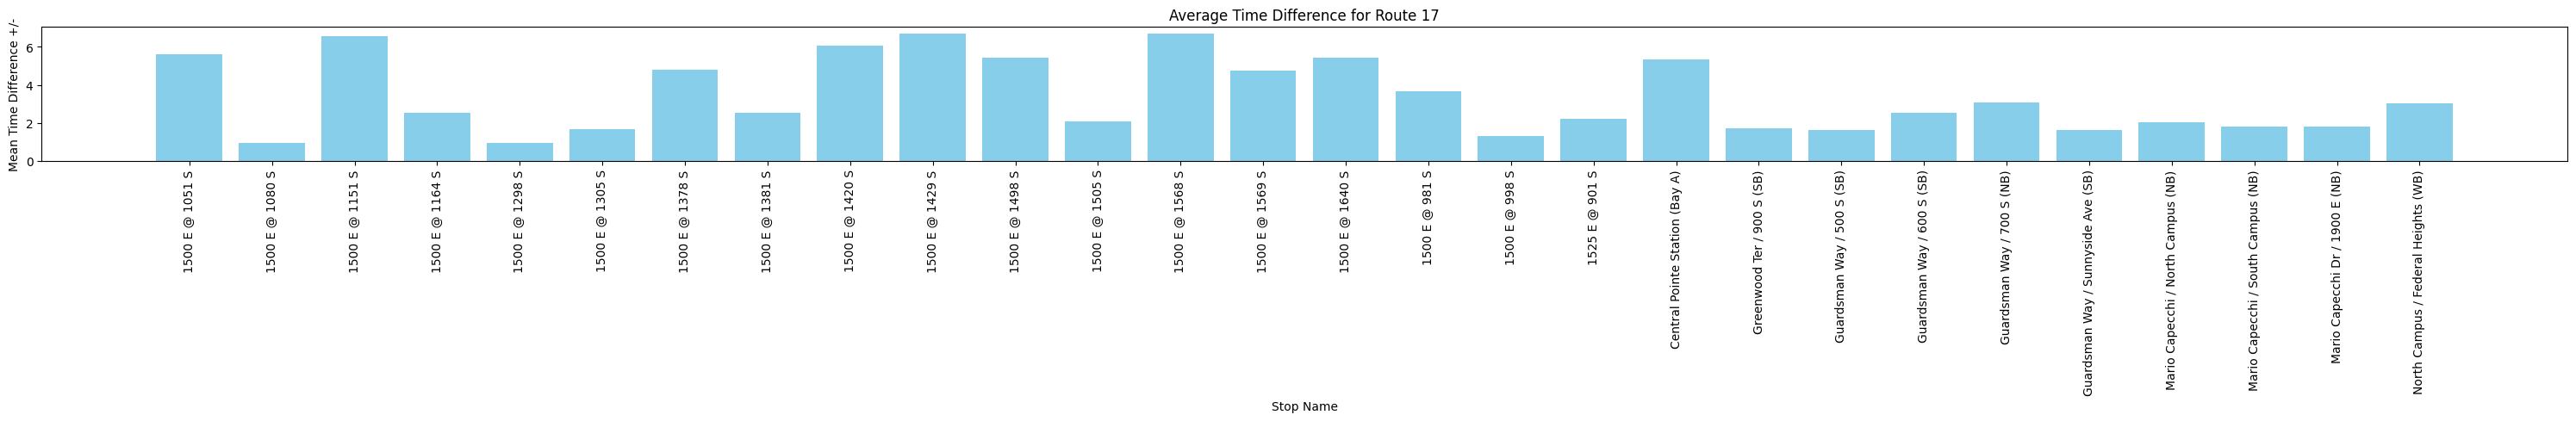

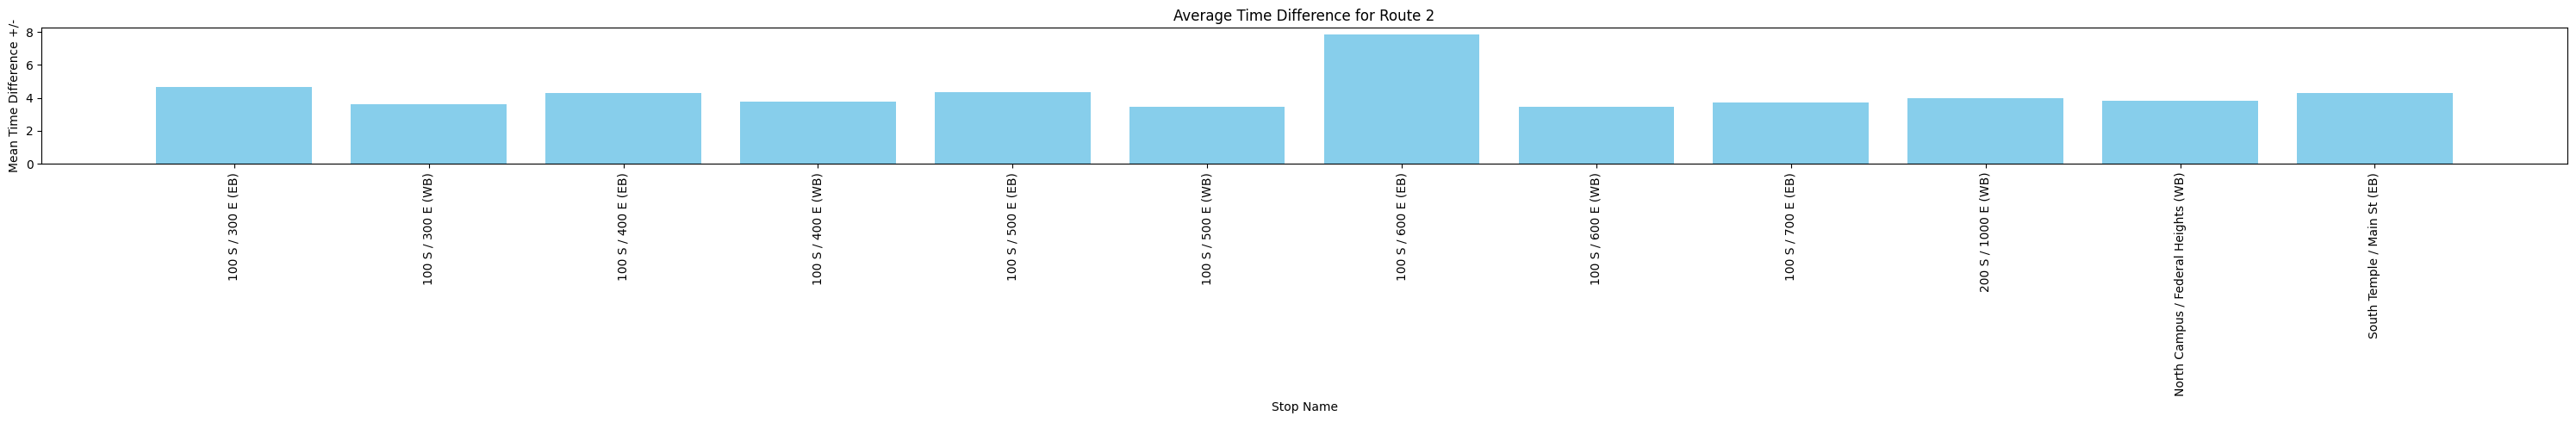

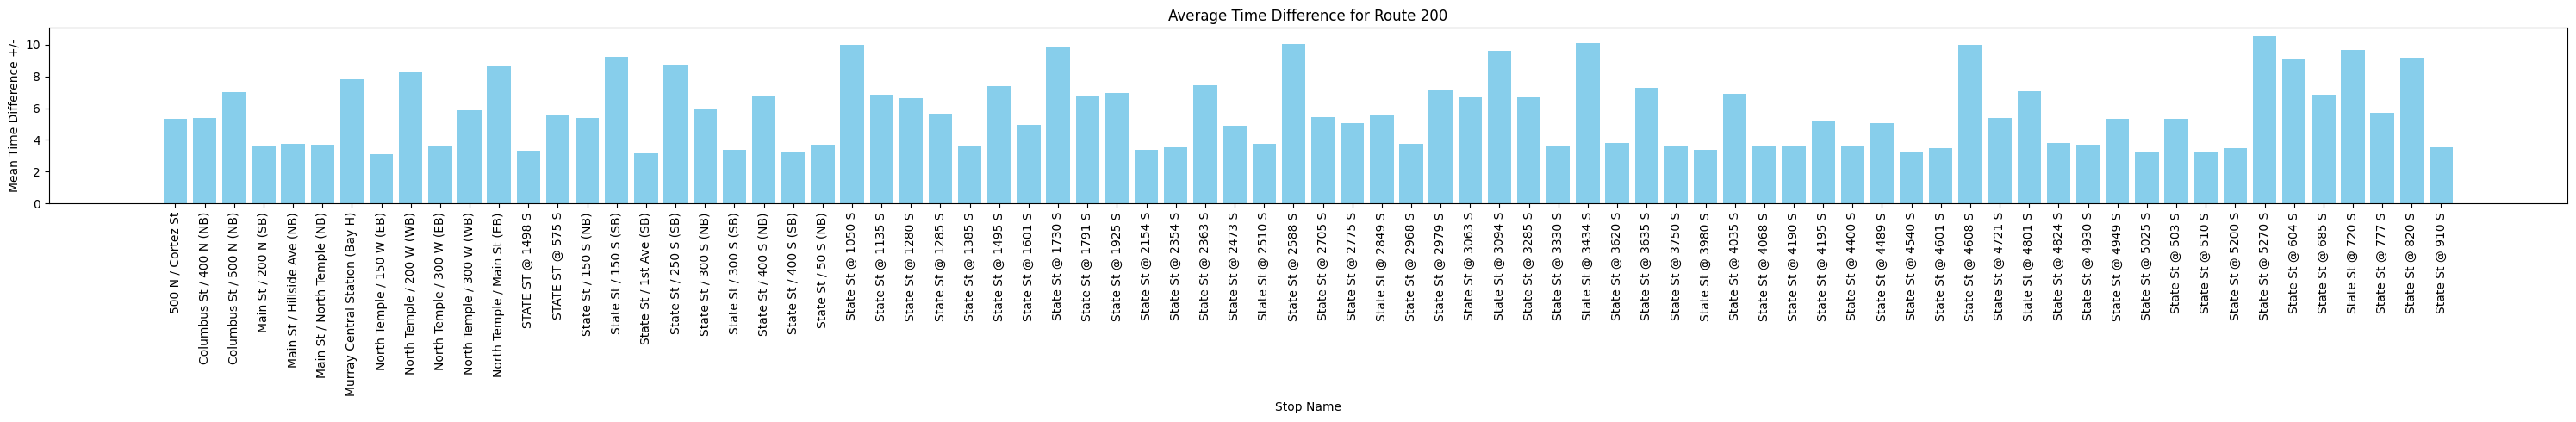

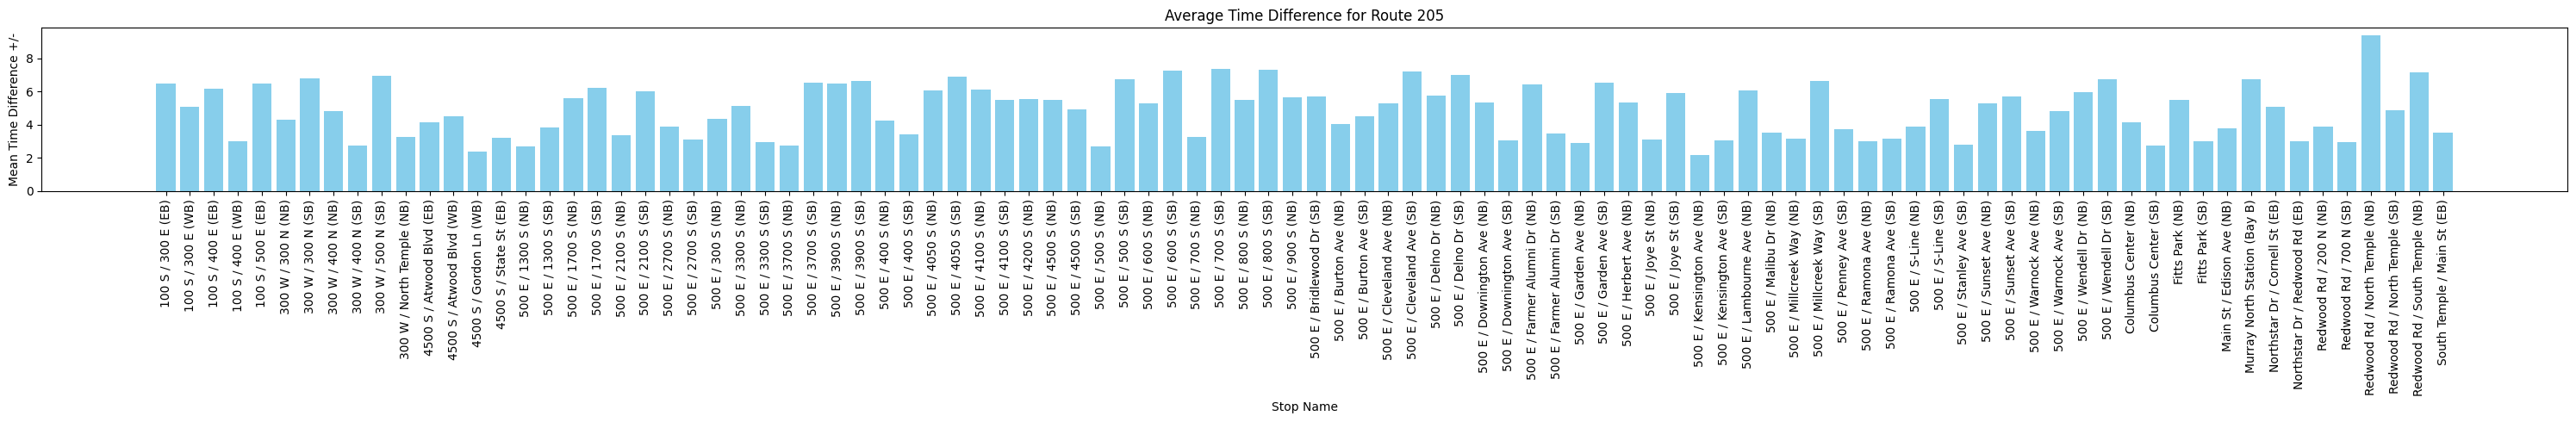

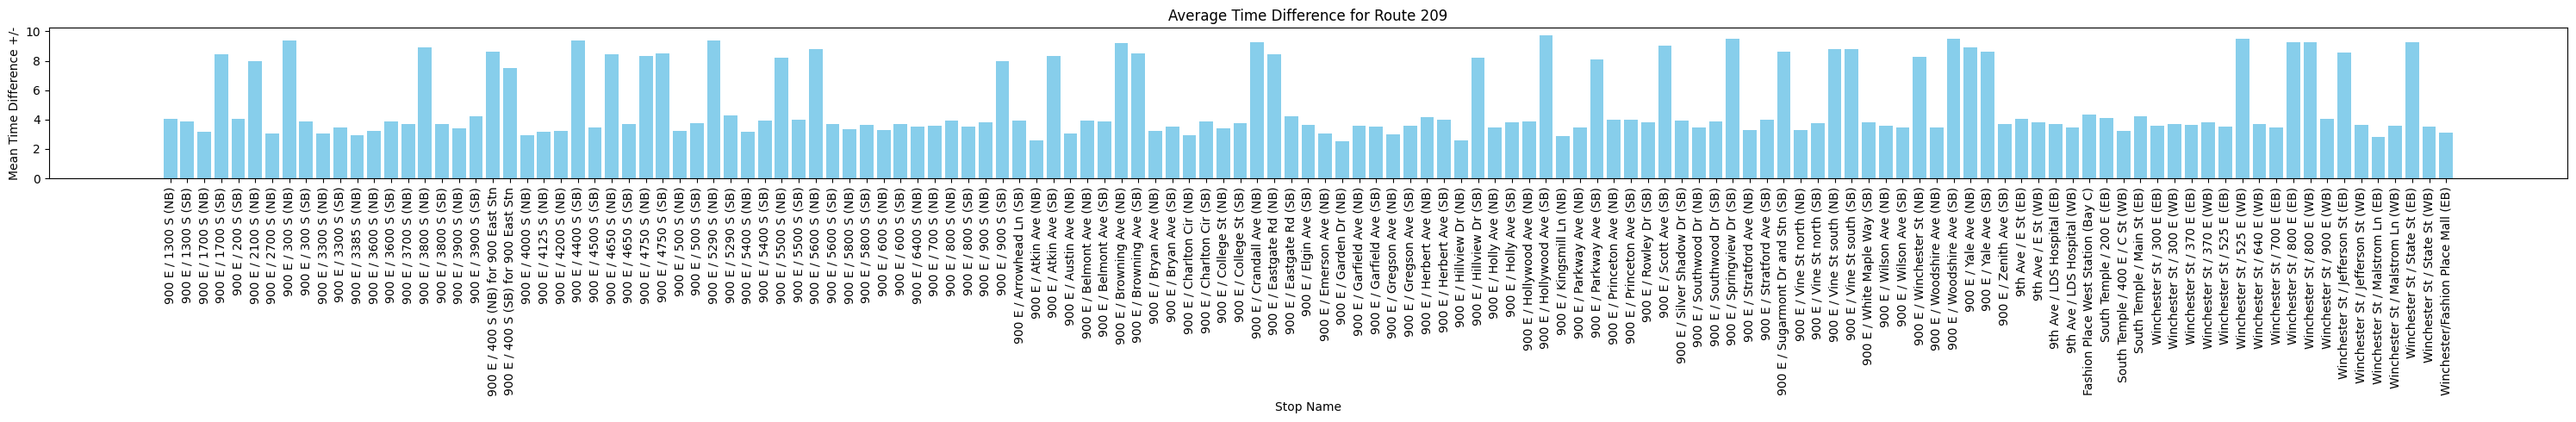

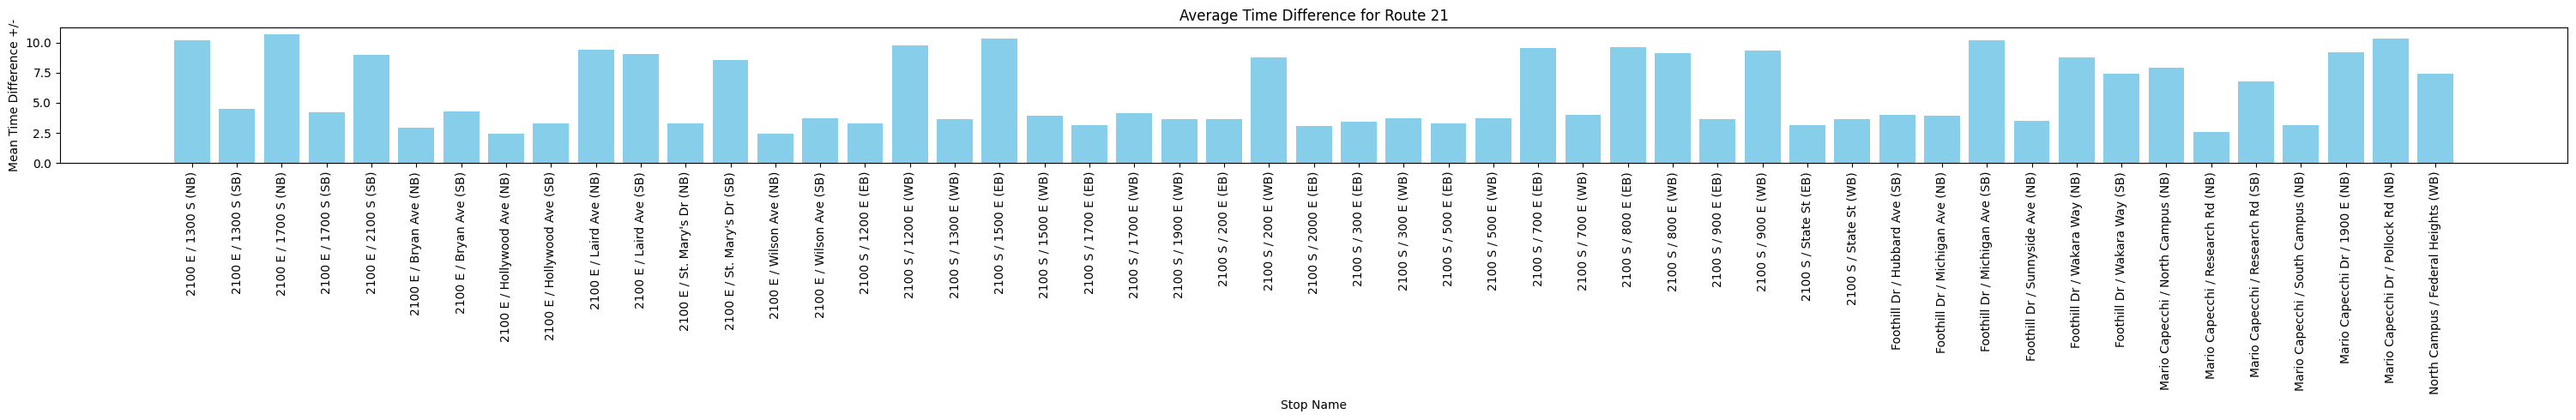

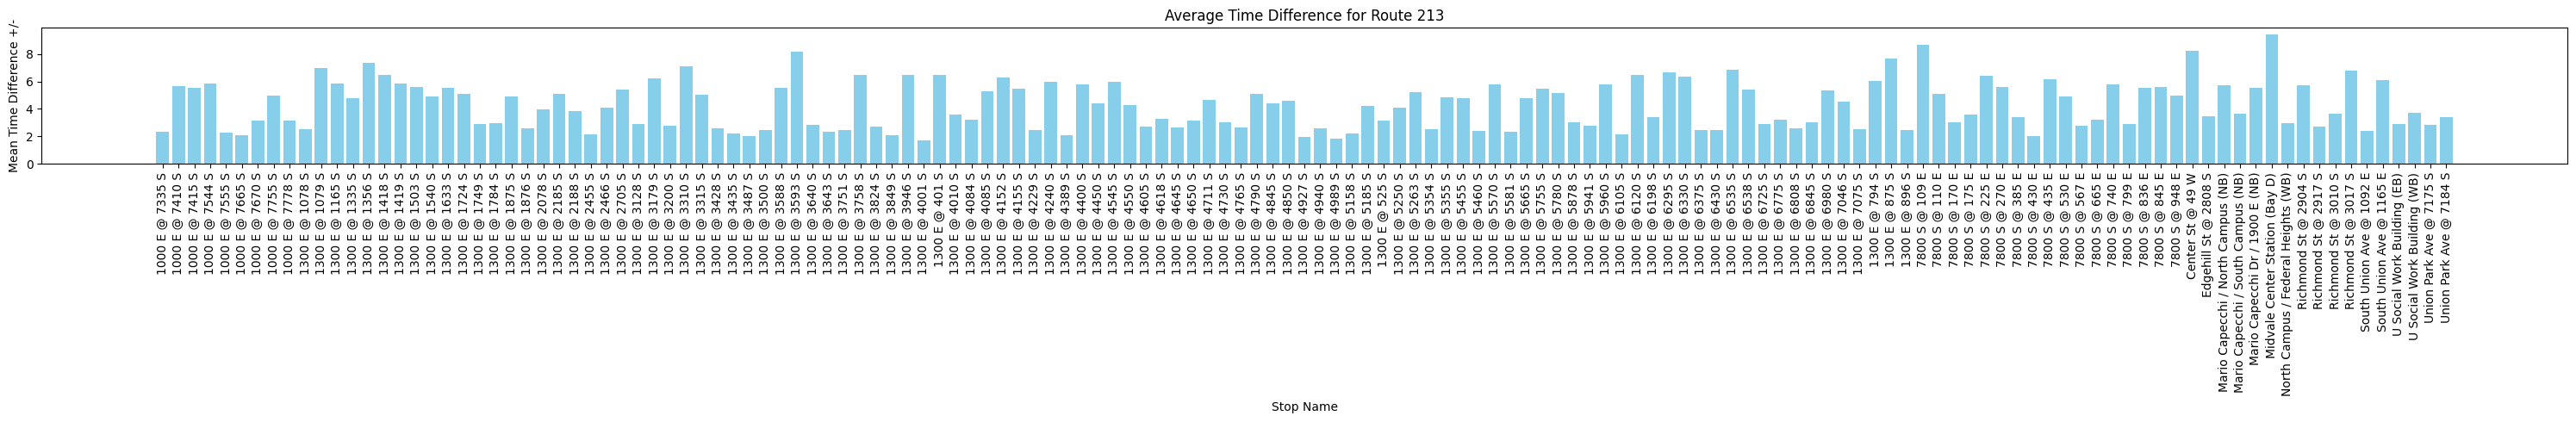

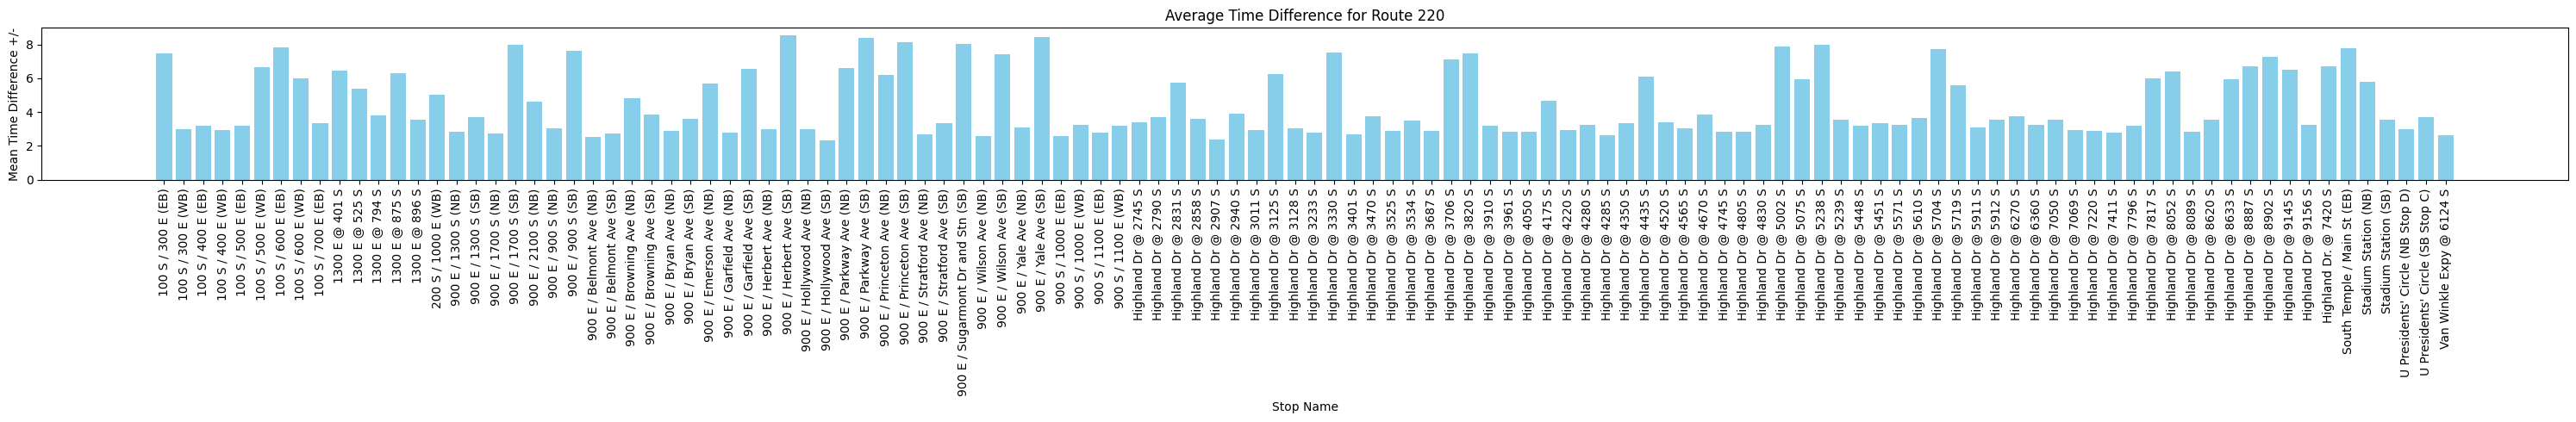

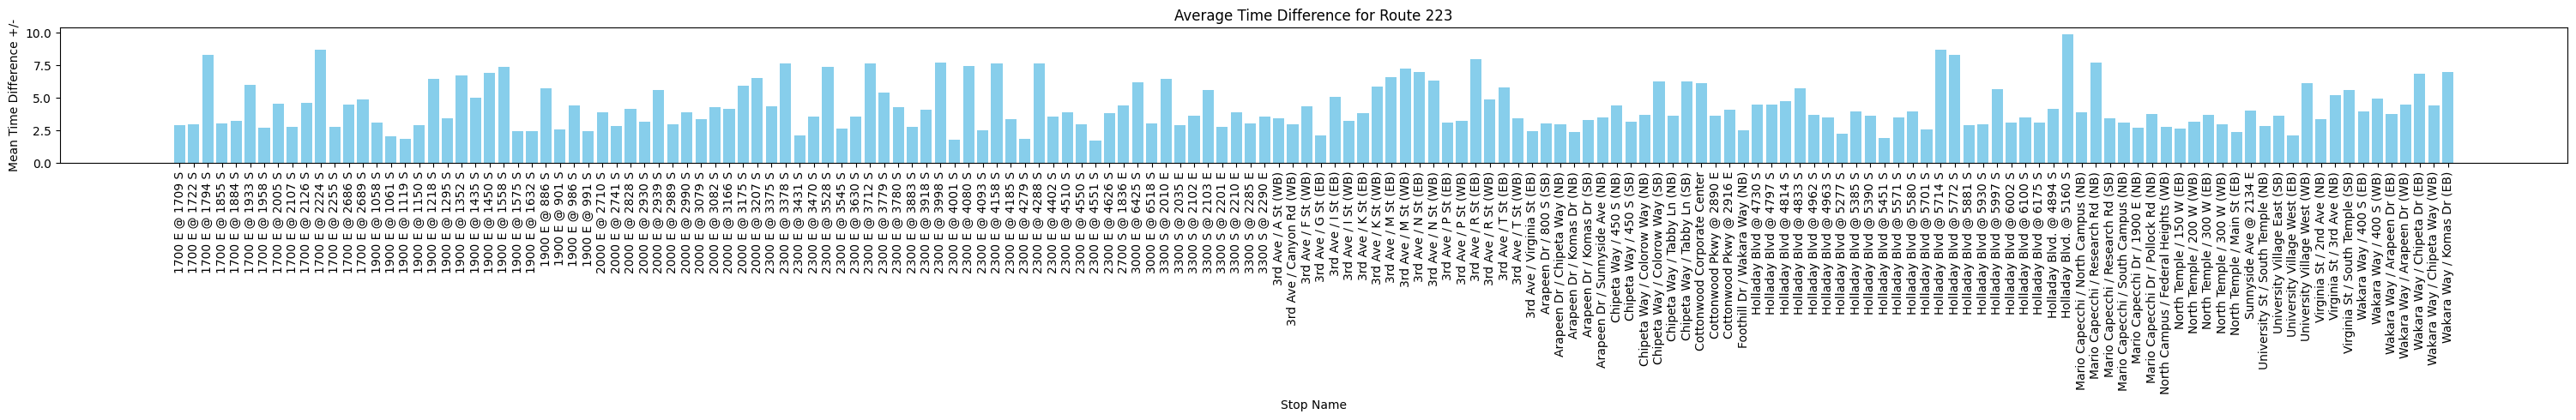

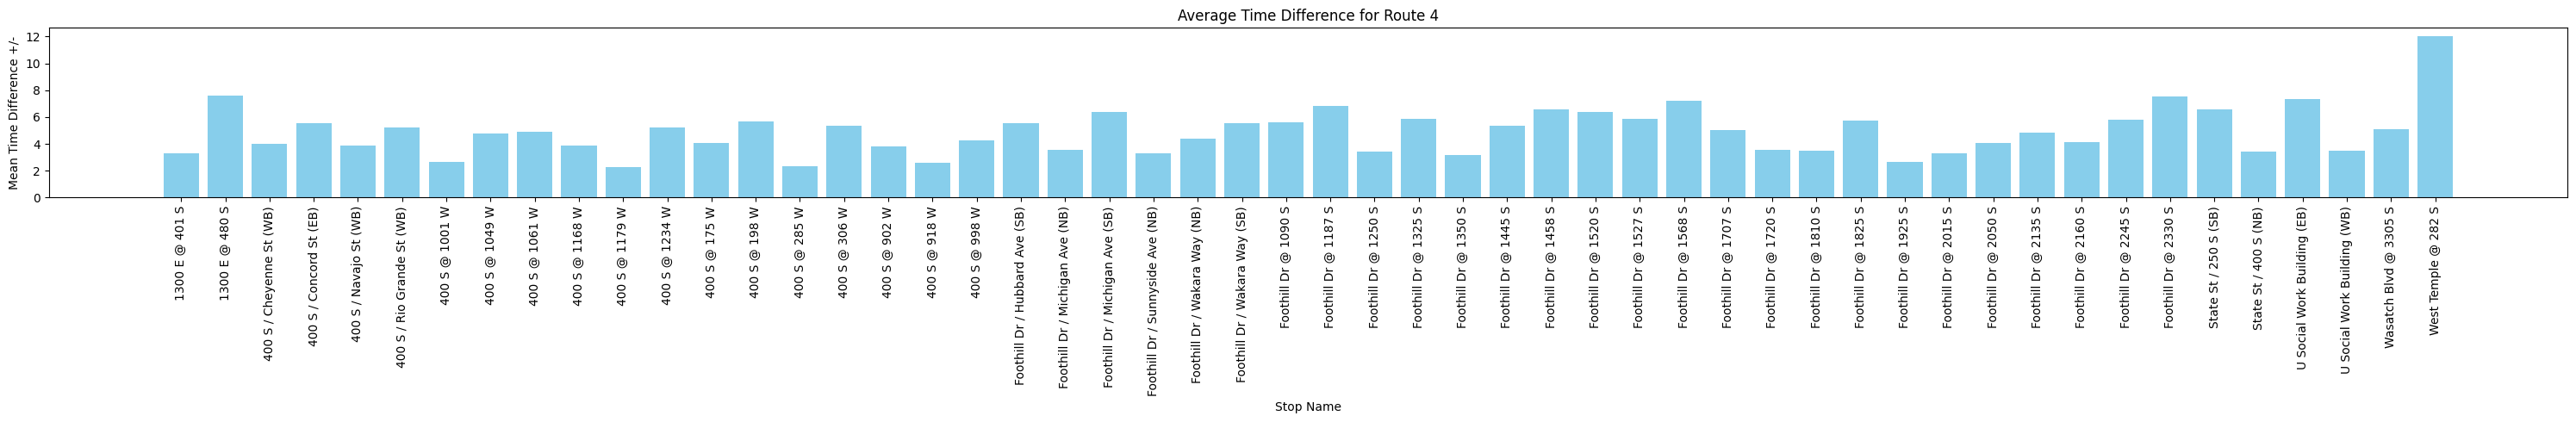

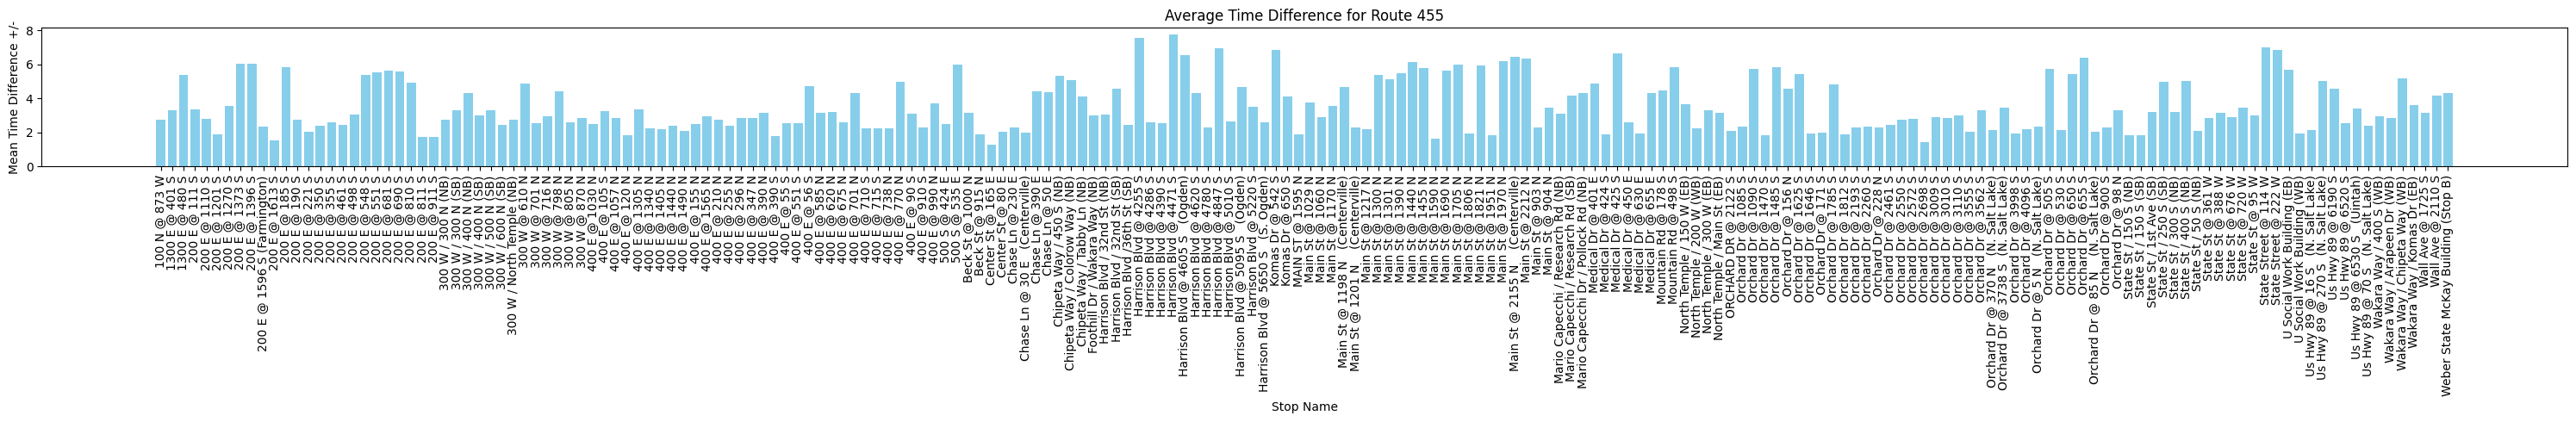

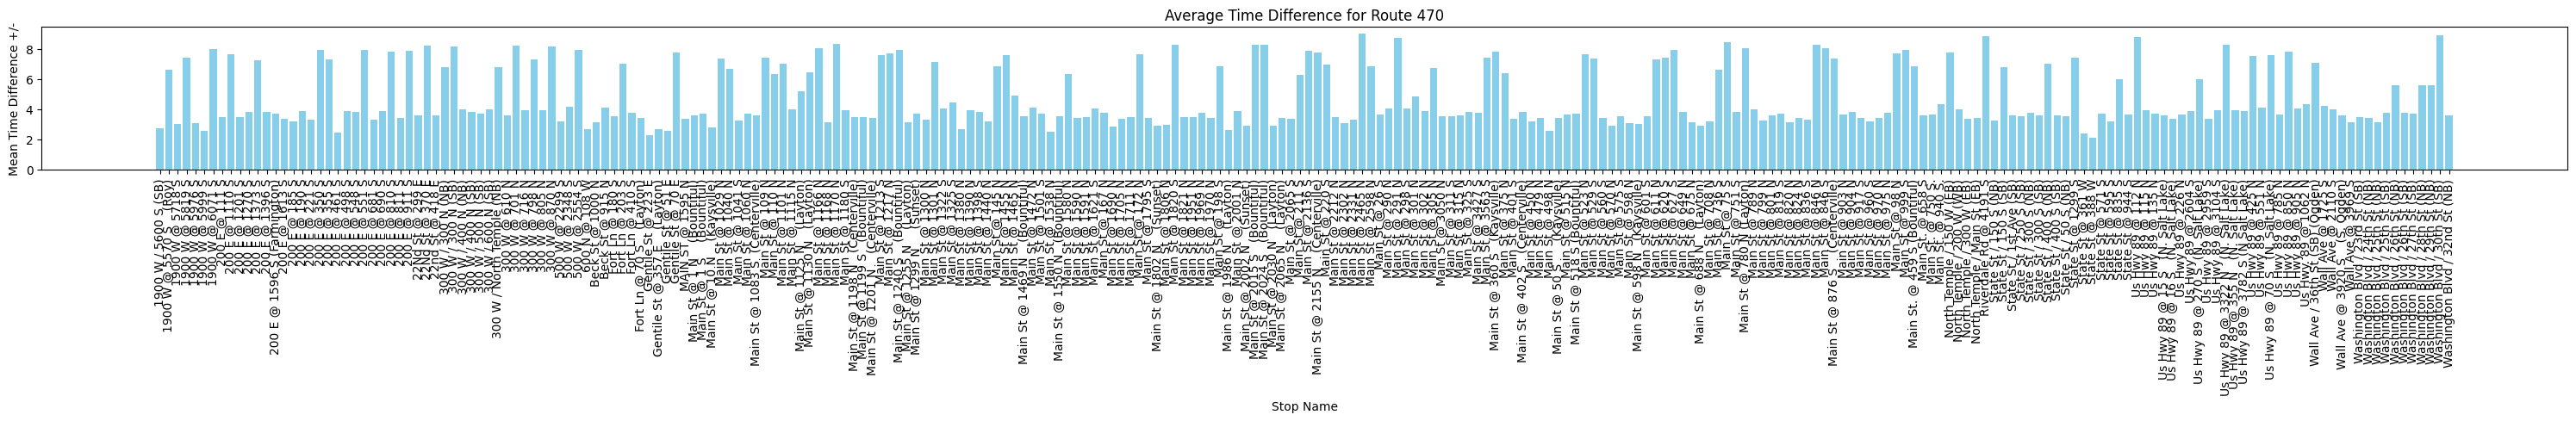

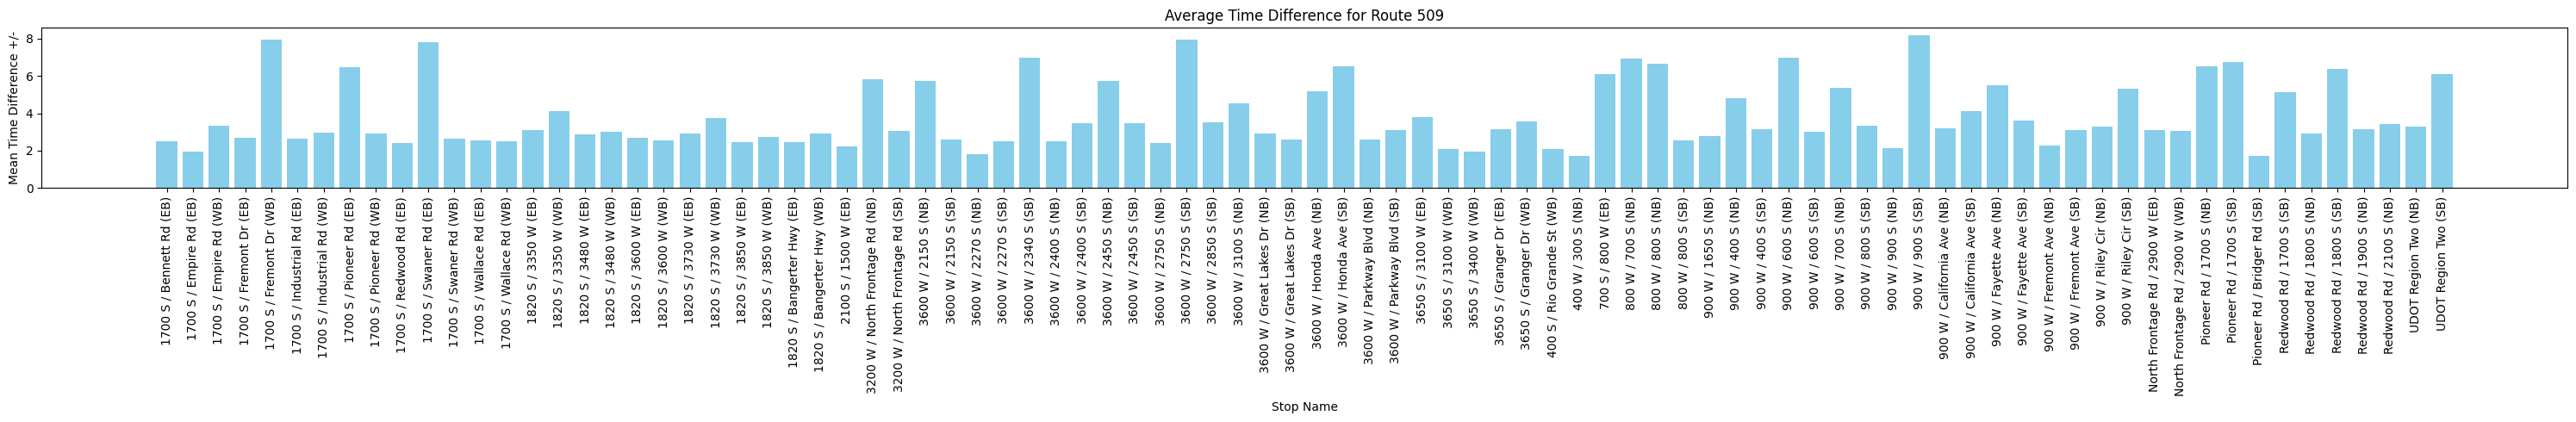

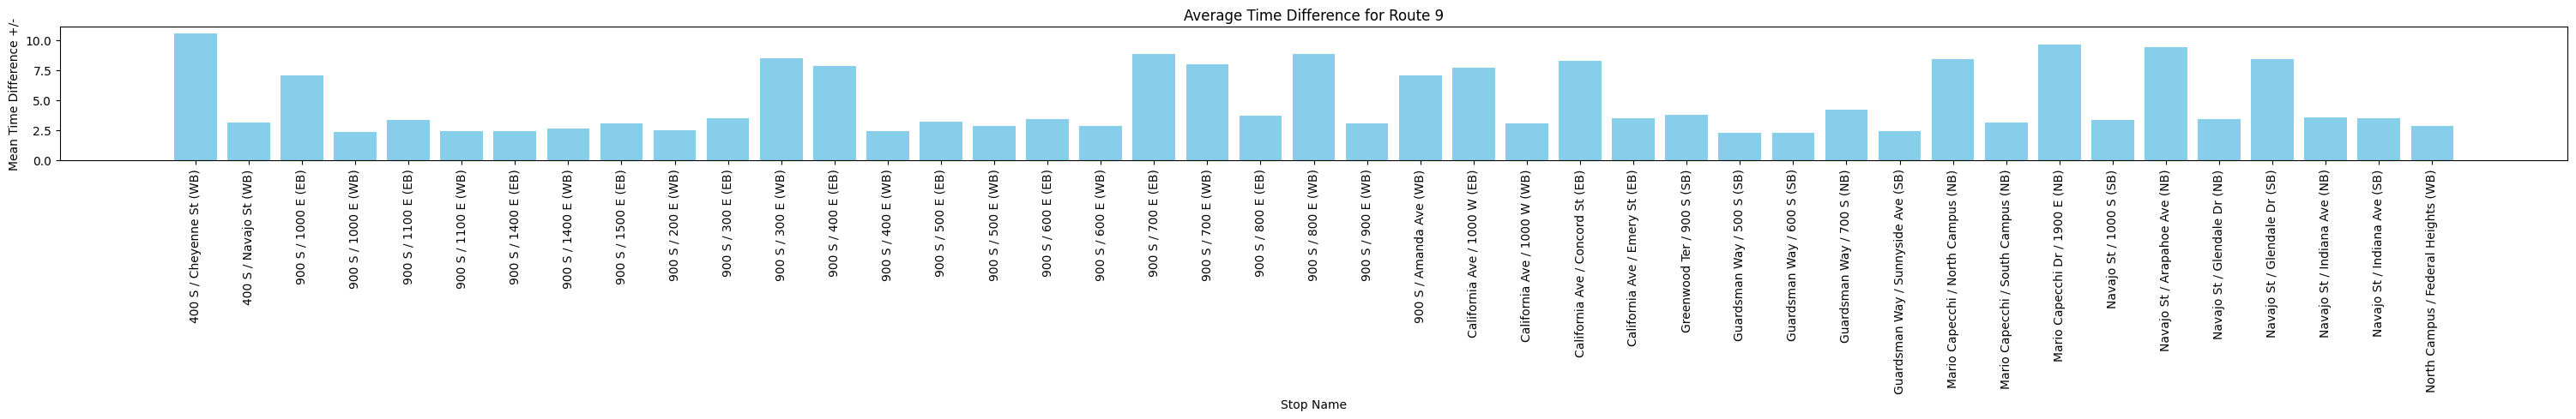

In [62]:
for route in routes:
    route_df = cleaned_times_df[cleaned_times_df['route'] == route]

    group = route_df.groupby('stop_name')['time_difference'].mean().reset_index()

    plt.figure(figsize=(30, 5))
    plt.bar(group['stop_name'], group['time_difference'], color='skyblue')
    plt.xlabel('Stop Name')
    plt.ylabel('Mean Time Difference +/-')
    plt.title(f'Average Time Difference for Route {route}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Additionally, I want to create a catplot to see the variance for our entire data set at each hour of the day. Catplots are great because they match the curve of the graph and also inform the reader of datapoints that fall outside of the curve. The trending variance at different times of day seems very strong. This catplot also matches what one would expect, with lower variance in the morning and evening when there are less riders and peaks during the daytime when people go to work.

In [63]:
def add_scheduled_hour(df):
    def round_hour(t):
        if t.minute >= 30:
            # Add one hour but reset to 0 if it's 24
            return (t.hour + 1) % 24
        else:
            return t.hour
    df['scheduled_hour'] = df['scheduled_arrival_time'].apply(round_hour)

    return df

In [64]:
cleaned_times_df = add_scheduled_hour(cleaned_times_df)

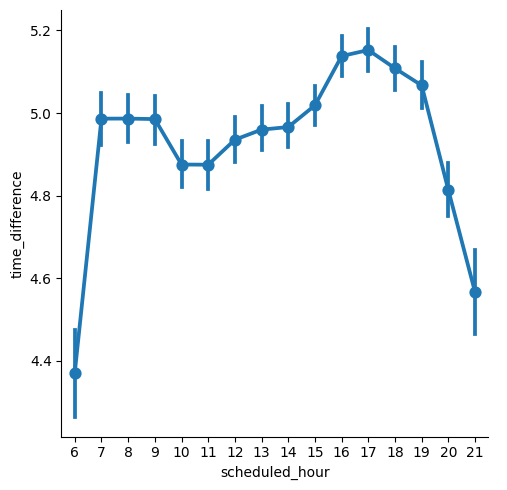

In [65]:
sb.catplot(data=cleaned_times_df, x='scheduled_hour', y='time_difference', kind='point')

In [66]:
cleaned_times_df.head()

vehicle_id  stop_id            stop_name  route               destination  \
0        15022     1022  University Hospital      1  Poplar Grove (Orange St)   
114      18002     1022  University Hospital      1  Poplar Grove (Orange St)   
163      15001     1022  University Hospital      1  Poplar Grove (Orange St)   
391      15009     1022  University Hospital      1  Poplar Grove (Orange St)   
534      13001     1022  University Hospital      1       University Hospital   

    scheduled_arrival_time actual_arrival_time  distance_to_stop  match_date  \
0                 06:05:00            06:00:00          1.741058  2024-04-12   
114               06:05:00            06:01:36          8.344103  2024-04-13   
163               06:05:00            06:00:13          9.102630  2024-04-11   
391               06:05:00            06:00:41          9.369665  2024-04-17   
534               19:35:00            19:35:37         22.023627  2024-04-12   

     time_difference  scheduled_hour  
0           5.000000               6  
114         3.400000               6  
163         4.783333               6  
391         4.316667               6  
534         0.616667              20

# Analysis

Above, we can see that our data displays patterns, but it is not linear. This means that normal linear regression models or multivariate linear regression models will not accurately represent the effect of time of day on the variance of the actual arrival times. To get a better idea we will use a spline linear regression model. Spline linear regression models split our data into segments, called splines, where we can then perform linear regression analyses on the data. After we peform our analyses, we will be able to look at effect each spline has on the model as a whole!

In [67]:
cleaned_times_df['minutes_since_midnight'] = cleaned_times_df['scheduled_arrival_time'].apply(lambda t: t.hour * 60 + t.minute)

transformed_x = dmatrix("bs(minutes_since_midnight, knots=(480, 720, 960), degree=3, include_intercept=False)",
                        data=cleaned_times_df, return_type='dataframe')

model_spline = sm.GLM(cleaned_times_df['time_difference'], transformed_x).fit()

print(model_spline.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        time_difference   No. Observations:               298363
Model:                            GLM   Df Residuals:                   298356
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          15.982
Method:                          IRLS   Log-Likelihood:            -8.3680e+05
Date:                Tue, 30 Apr 2024   Deviance:                   4.7683e+06
Time:                        22:18:05   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0009383
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

After creating our model, we can see some really valuable information. The pearson chi squared test gave us a value extremely close to zero, 0.0000047. The chi squared test is a test that determines the probability the independent variable, hour of the day, not having an effect on the variance of the time. With such low probability, we can accept our hypothesis which is that we can predict the variance of a bus based on the time of day and reject the null hypothesis that the time of day doesn't have an effect on the variance of actual arrival times.

Additionally, this test allows us to see each spline's analyses as well. For each spline, we got p values all lower than 0.05. This means that for each spline component we can accept our hypothesis and reject the null hypothesis. We also are able to see the coefficient of each spline, which is how much the spline component affects the prediction on time difference. The z value for each spline is high, each higher than 2, which indicates the coefficient is significantly different from zero at conventional levels. The confidence interval shows us a range of coeficients for each spline where we can be 95% sure contains the true effect size.

# Graphing our results

Now that we have accepted our hypothesis, we can graph the results of the spline linear regression model. To visualize the model, we will graph each spline component's effect on the variance of the actual arrival time of busses through the period in which I collected data, 6AM-9PM. We will then add another line which shows the cumuluative effect of the each spline component on the variance of the time.

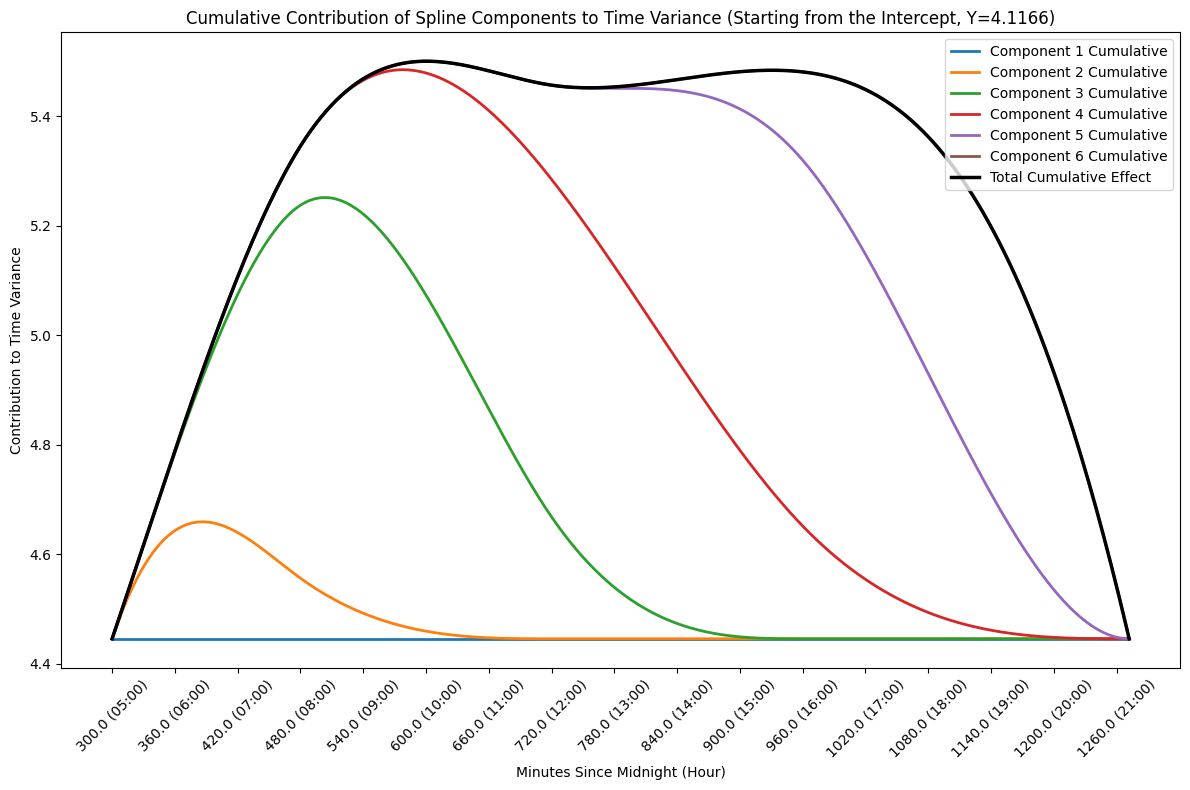

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrix


coefficients = model_spline.params

x_range = np.linspace(300, cleaned_times_df['minutes_since_midnight'].max(), 400)

x_basis = dmatrix("bs(x, knots=(480, 720, 960), degree=3, include_intercept=False)", {"x": x_range}, return_type='dataframe')

cumulative_effect = np.full_like(x_range, coefficients[0], dtype=float)

plt.figure(figsize=(12, 8))

for i in range(1, len(coefficients)):
    component_effect = x_basis.iloc[:, i - 1] * coefficients[i]
    cumulative_effect += component_effect
    plt.plot(x_range, cumulative_effect, label=f'Component {i} Cumulative', linewidth=2)

plt.plot(x_range, cumulative_effect, color='black', label='Total Cumulative Effect', linewidth=2.5)

def minutes_to_hour_string(minutes):
    hours = minutes // 60
    mins = minutes % 60
    return f"{int(hours):02d}:{int(mins):02d}"

xticks = np.arange(300, x_range[-1] + 1, 60)
xtick_labels = [f"{x} ({minutes_to_hour_string(x)})" for x in xticks]

plt.xticks(xticks, xtick_labels, rotation=45)
plt.title('Cumulative Contribution of Spline Components to Time Variance (Starting from the Intercept, Y=4.1166)')
plt.xlabel('Minutes Since Midnight (Hour)')
plt.ylabel('Contribution to Time Variance')
plt.legend()
plt.tight_layout()
plt.show()


This graph shows the effect of each spline component on the entire model. Since this graph is a model for all our data, in other words each tracked route, it is a very generalized model that will be accurate for most busses at most times. However, we can filter our data by route and then perform the same graphing analyses to get even more specific variance data.

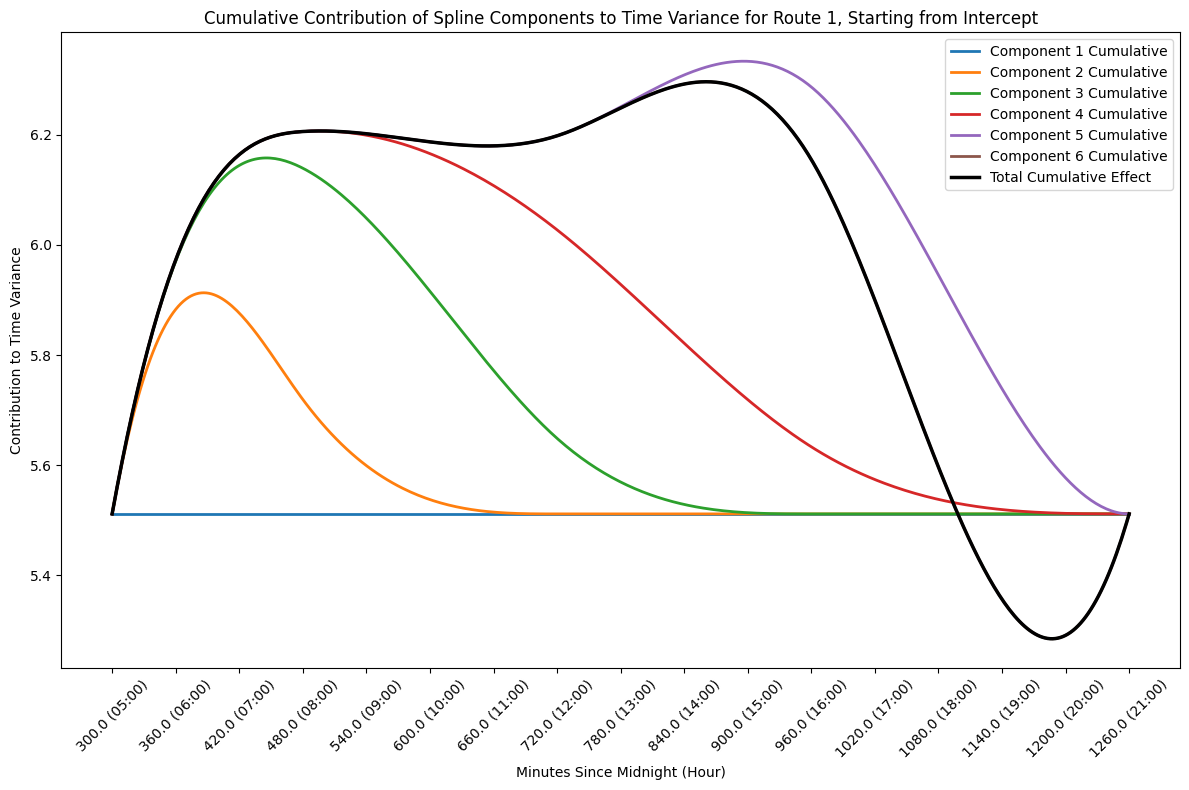

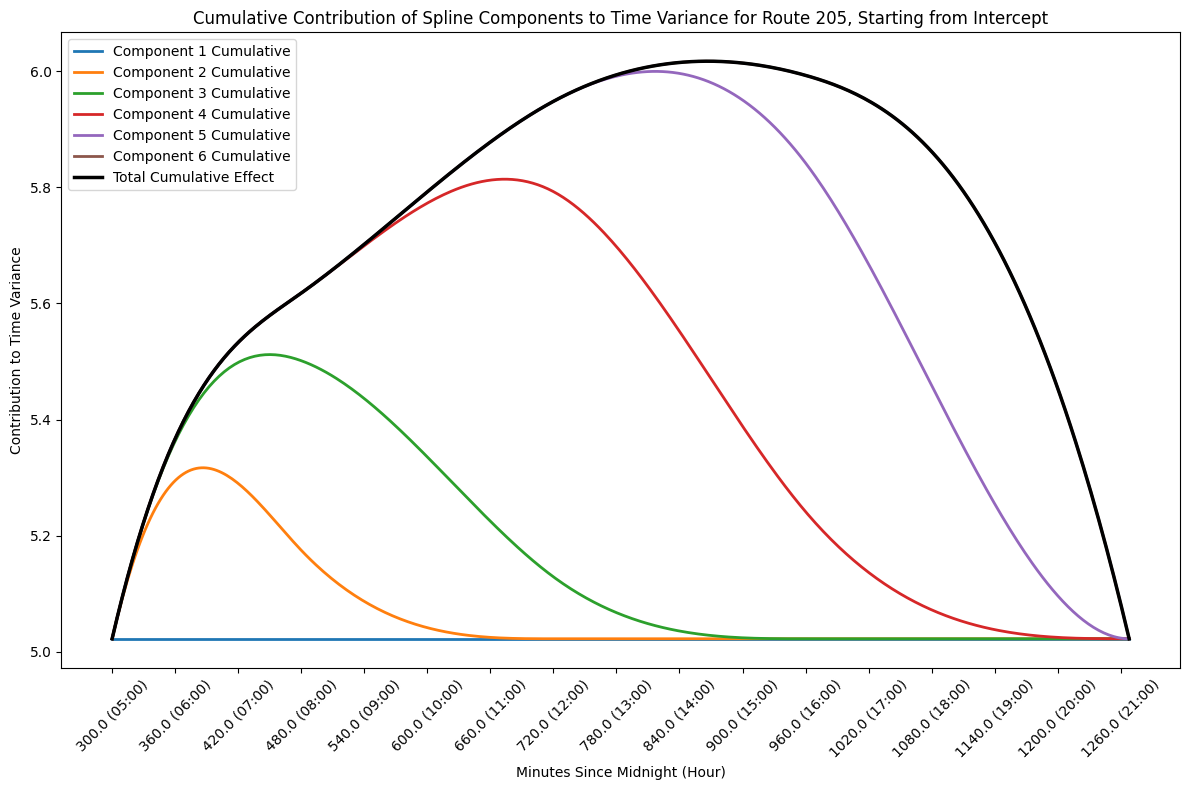

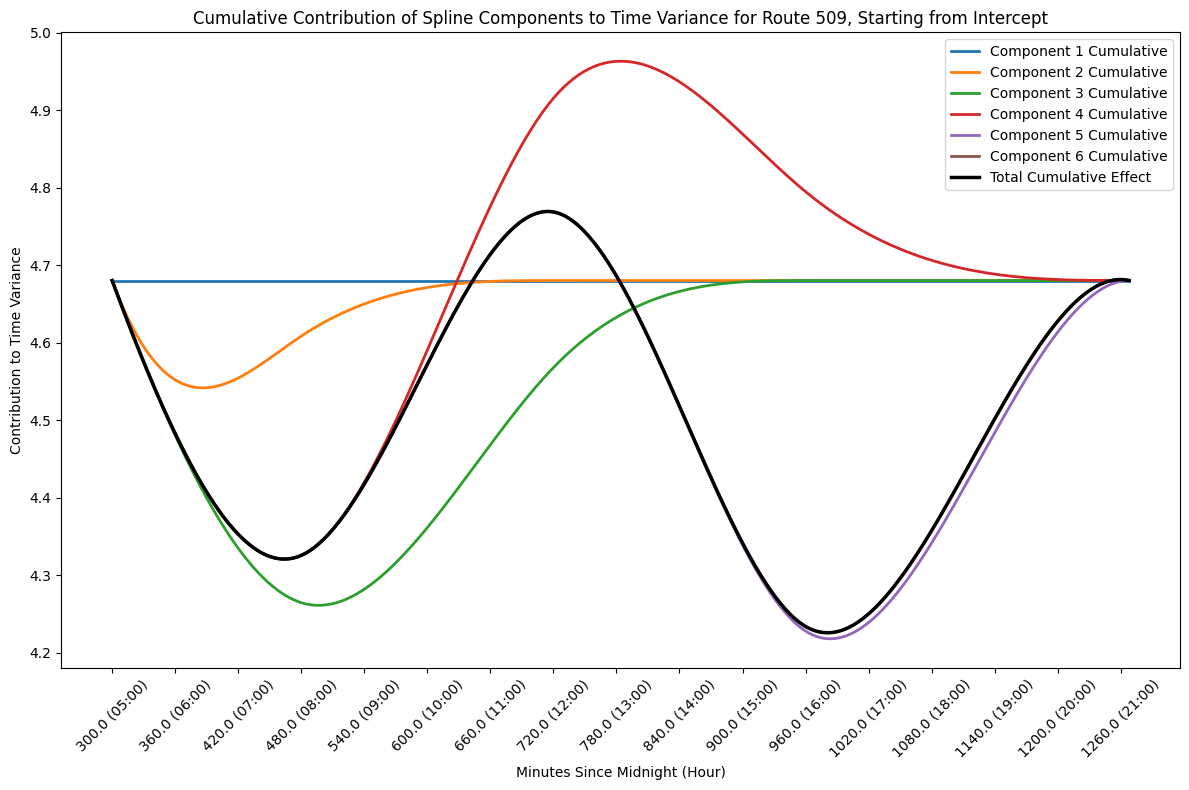

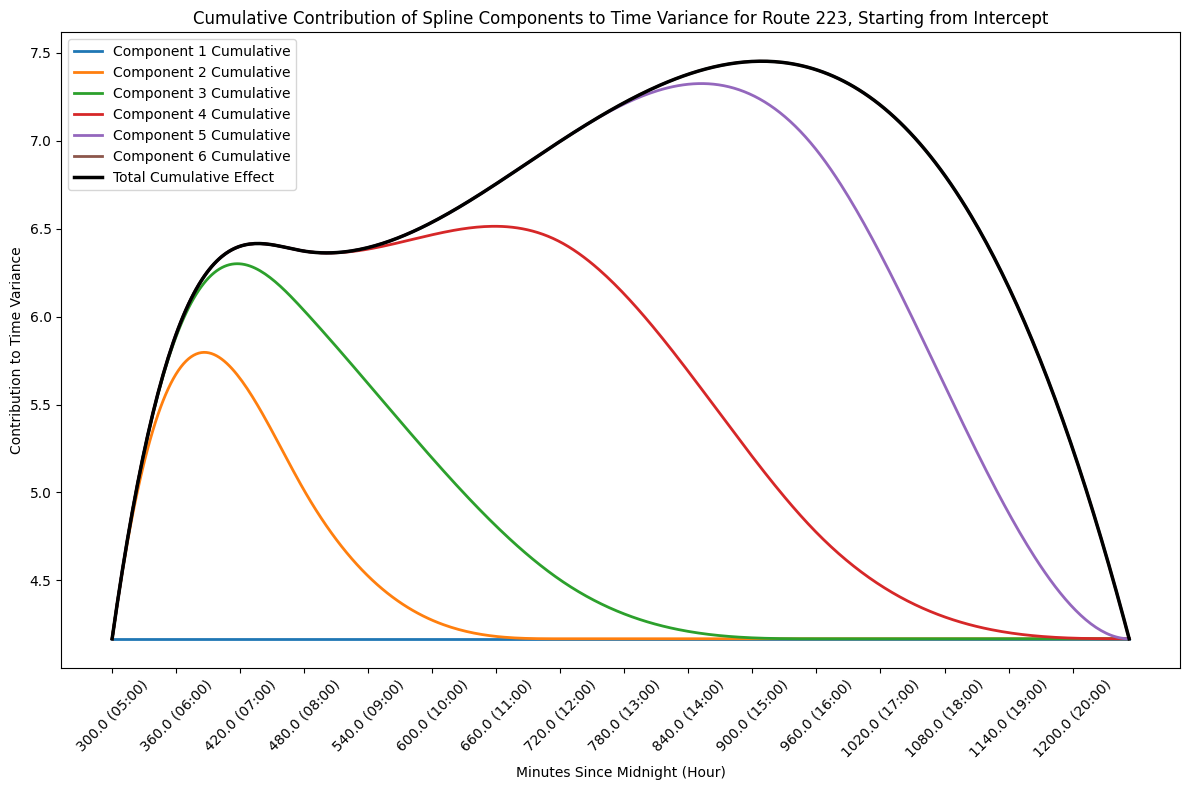

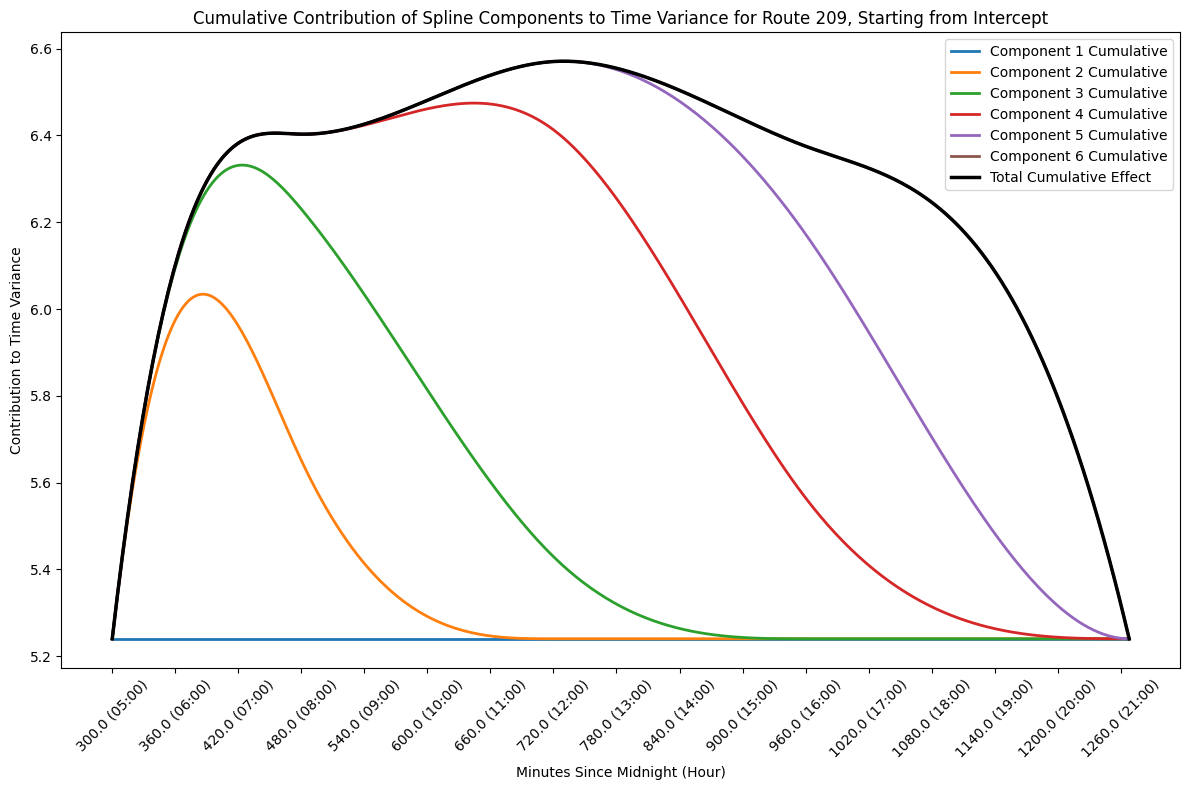

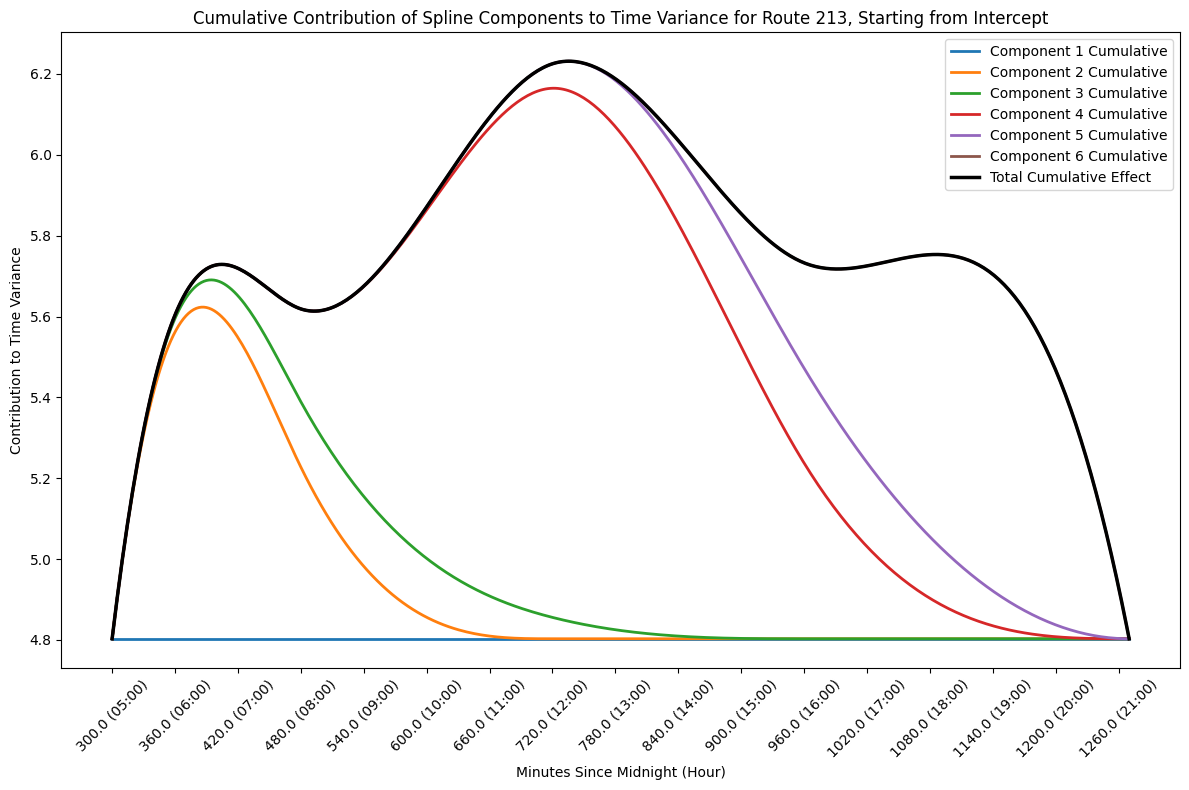

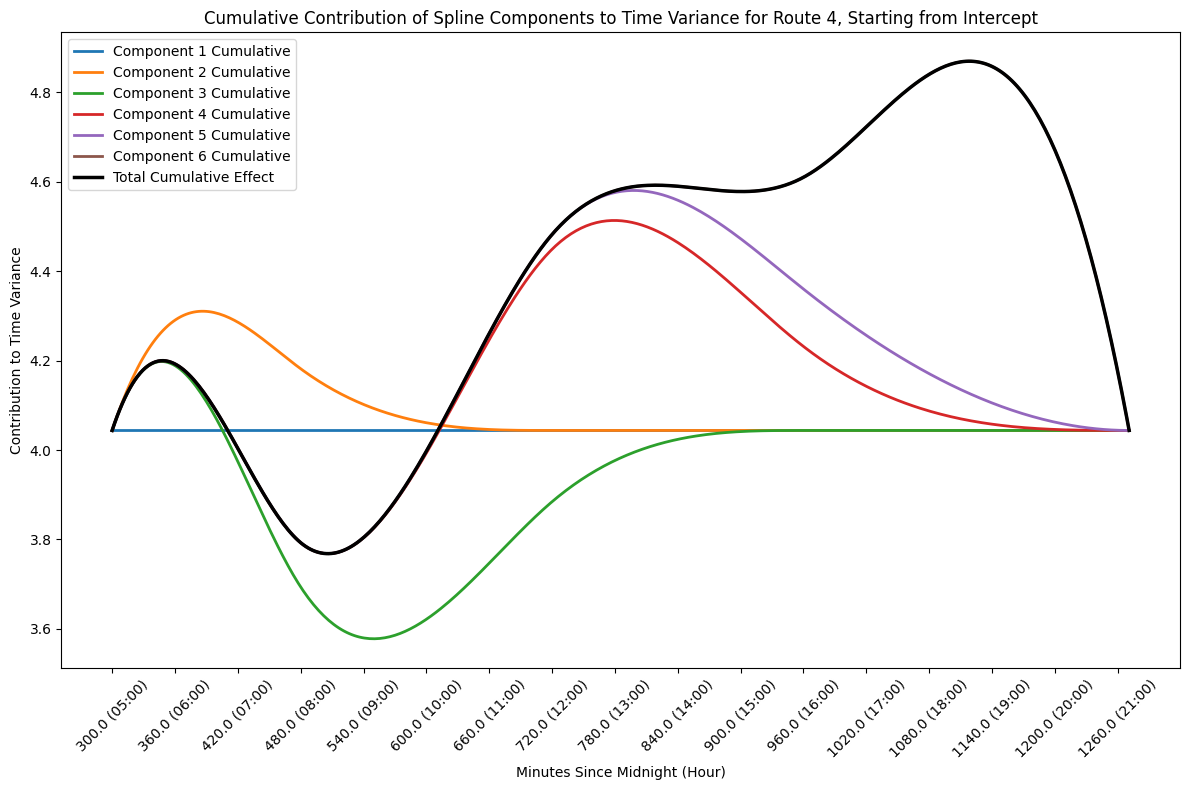

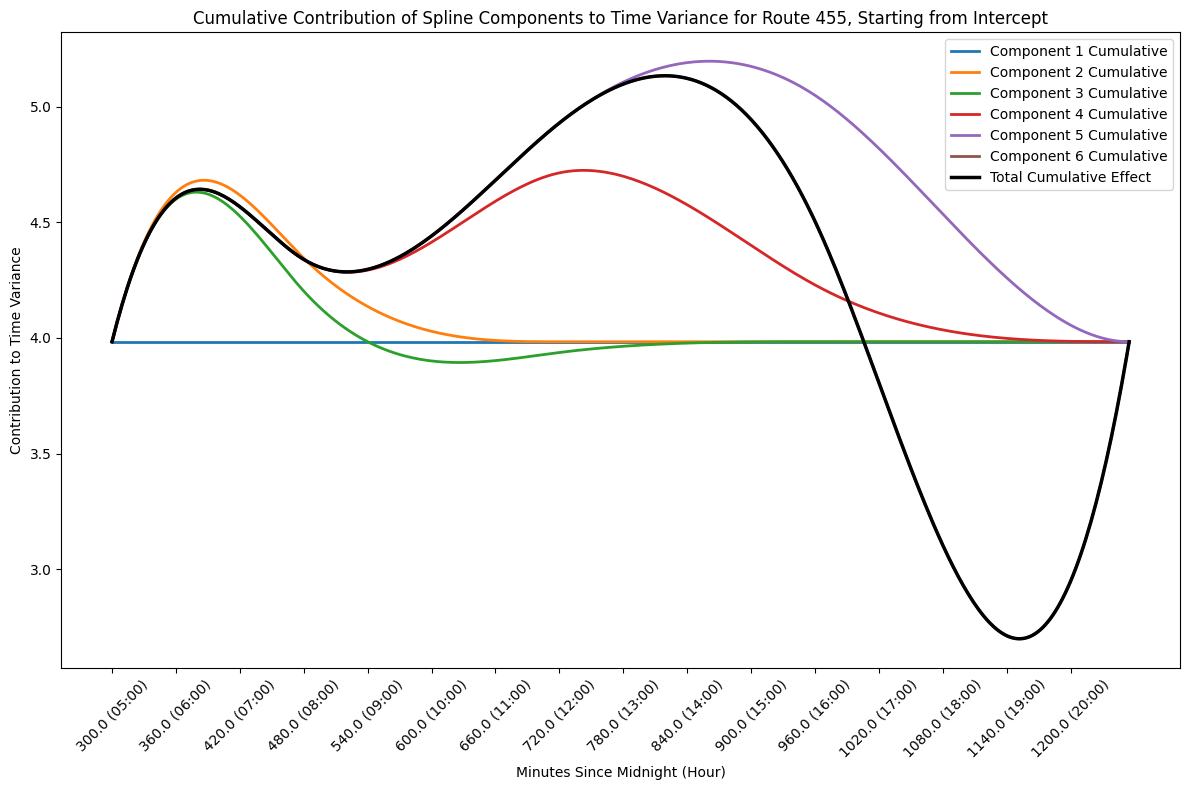

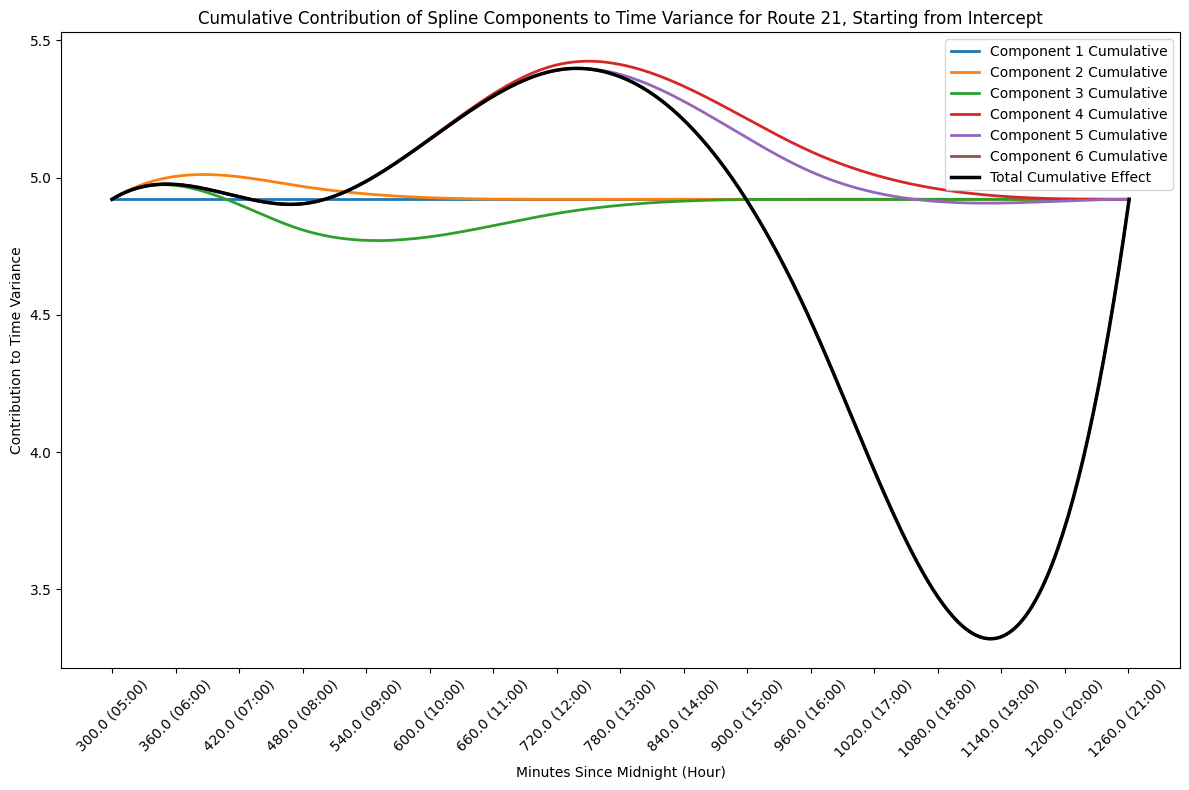

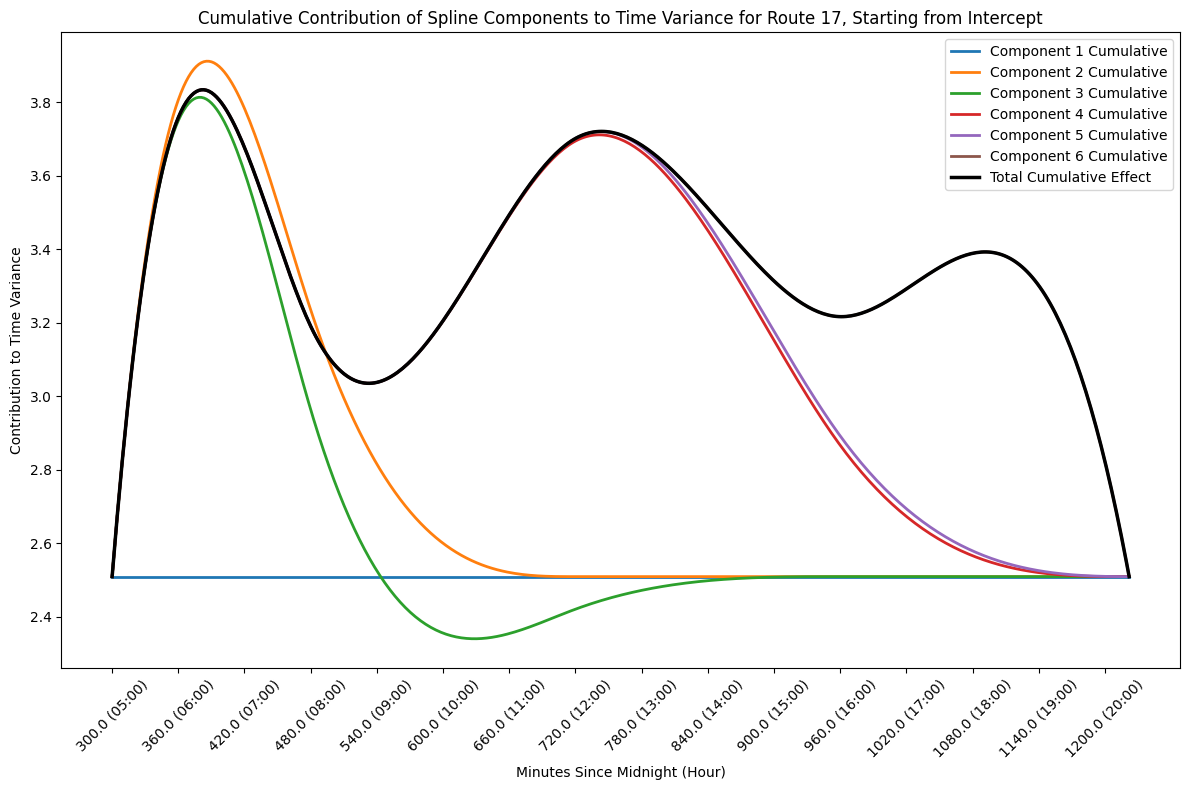

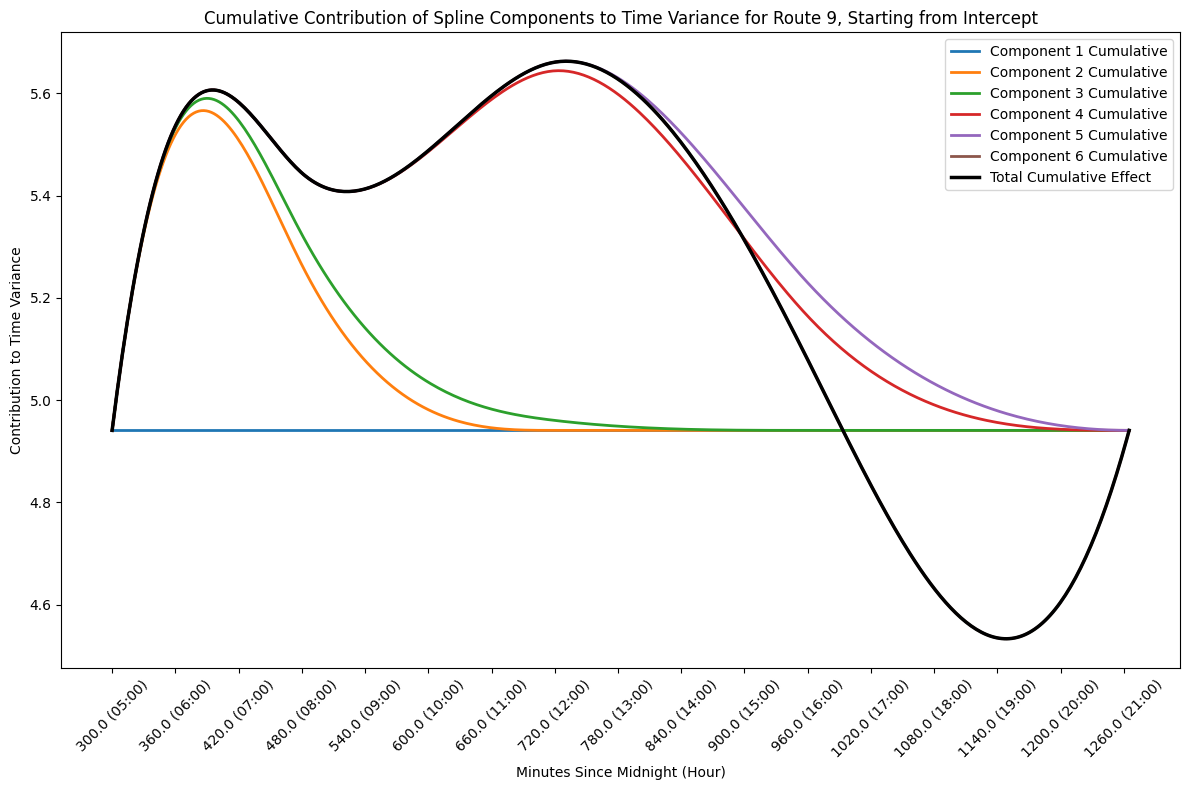

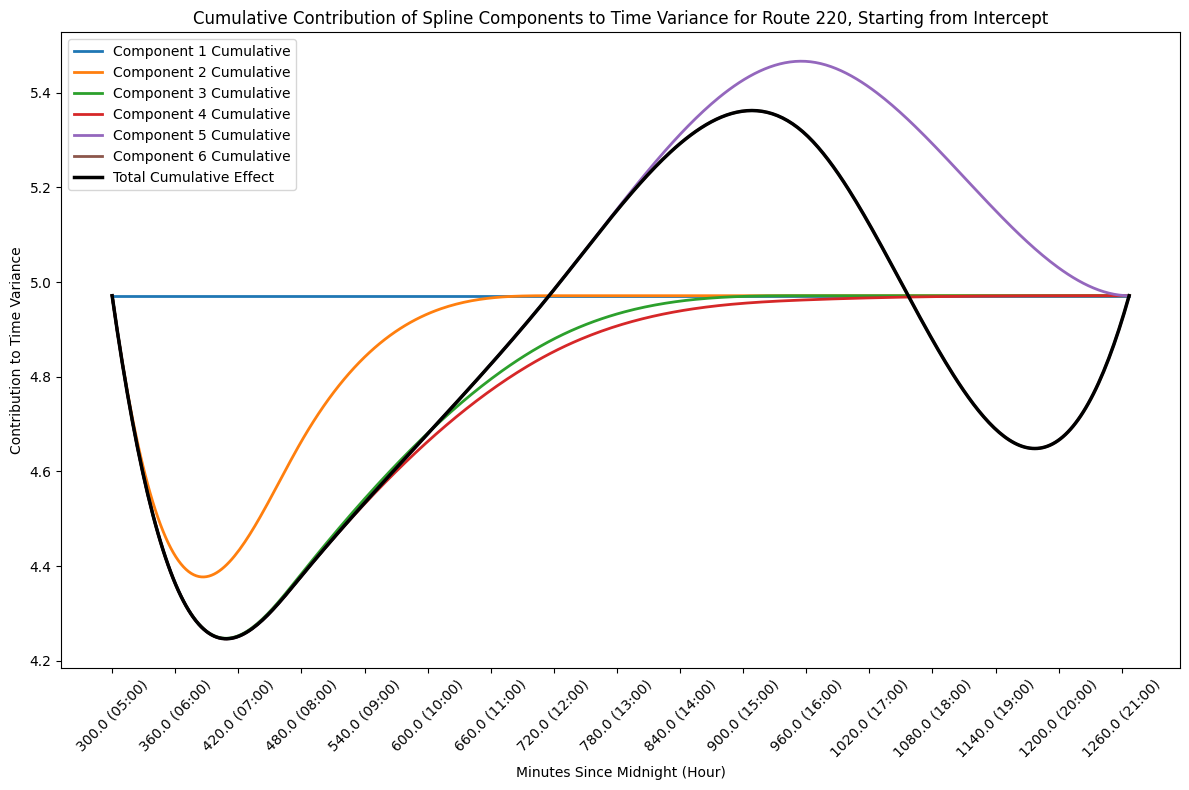

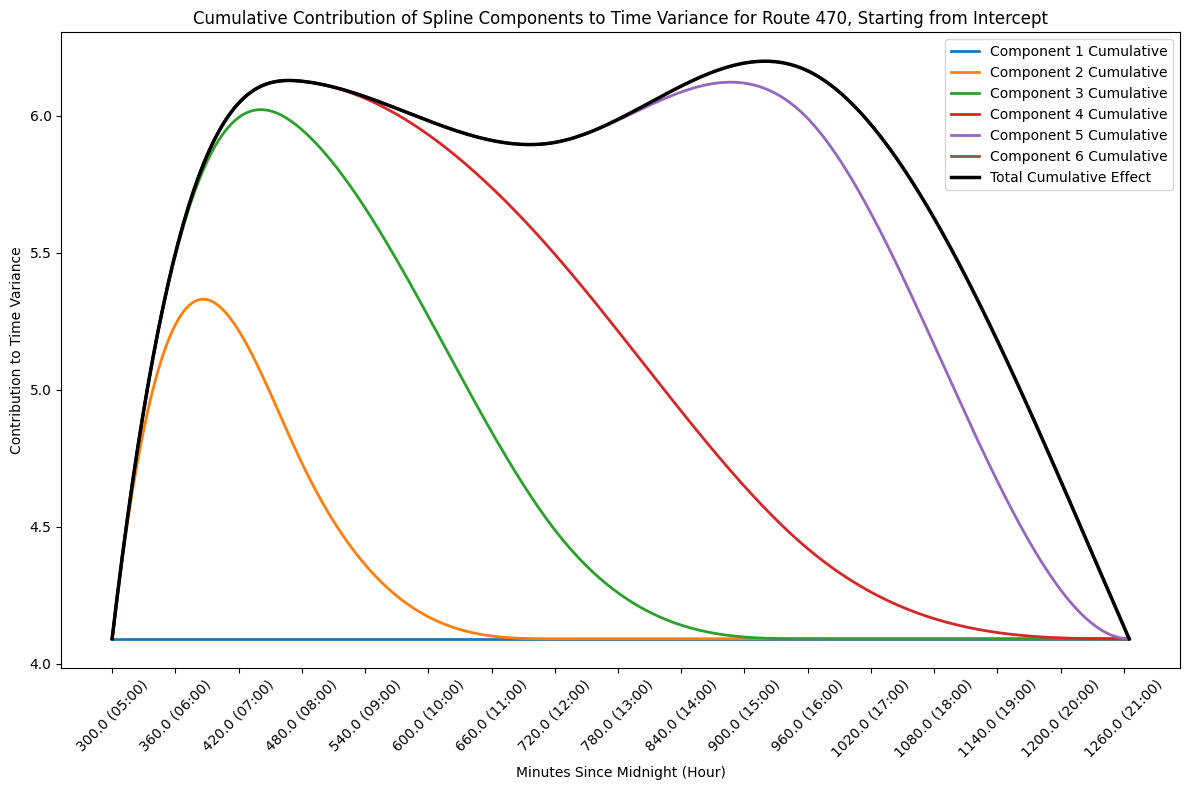

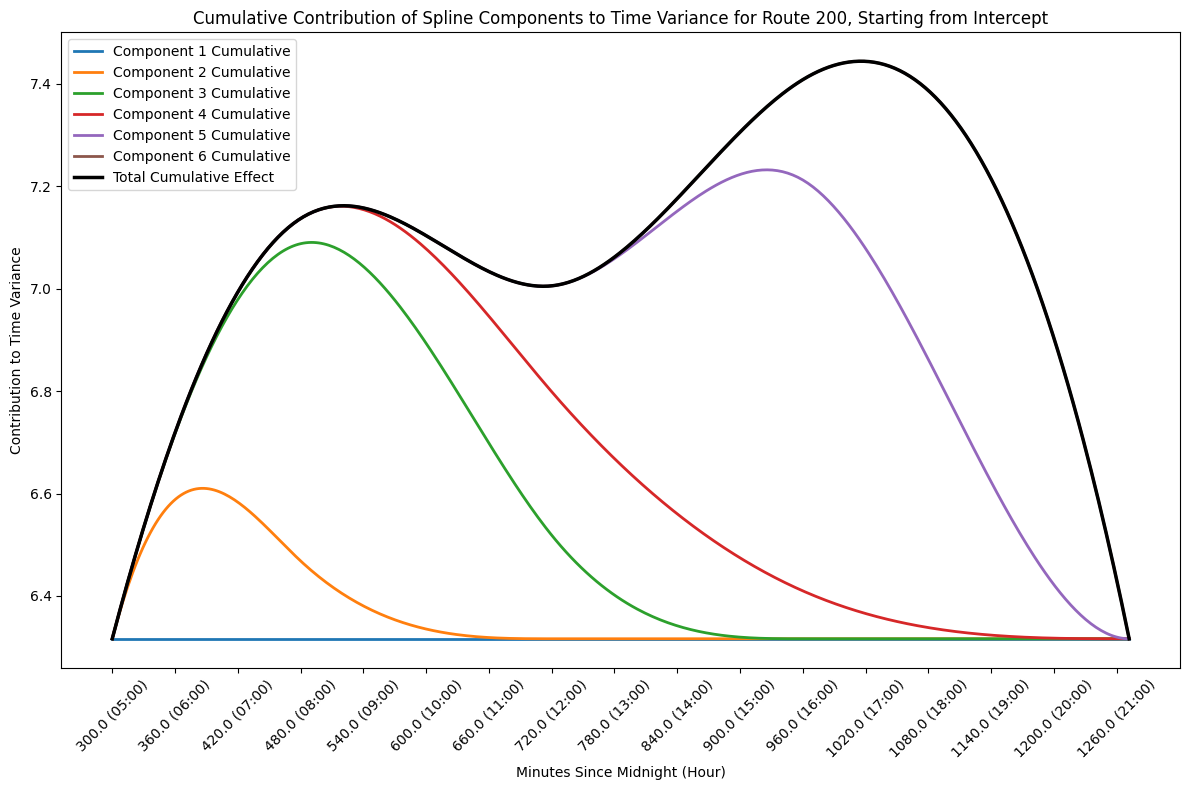

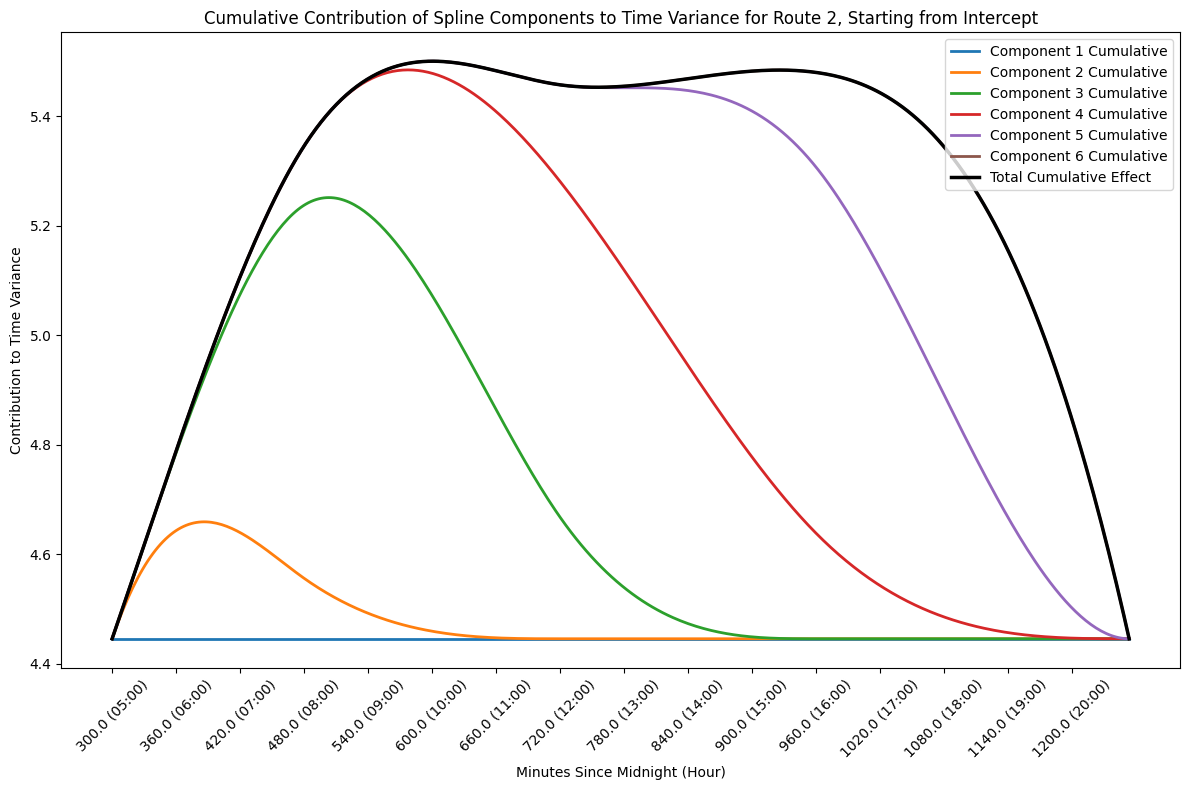

In [74]:
import statsmodels.api as sm
routes = cleaned_times_df['route'].unique()

for route in routes:
    df_route = cleaned_times_df[cleaned_times_df['route'] == route].copy()
    df_route['minutes_since_midnight'] = df_route['scheduled_arrival_time'].apply(lambda t: t.hour * 60 + t.minute)

    transformed_x = dmatrix("bs(minutes_since_midnight, knots=(480, 720, 960), degree=3, include_intercept=False)",
                            data=df_route, return_type='dataframe')

    model_spline = sm.GLM(df_route['time_difference'], transformed_x).fit()

    x_range = np.linspace(300, df_route['minutes_since_midnight'].max(), 400)
    x_basis = dmatrix("bs(x, knots=(480, 720, 960), degree=3, include_intercept=False)",
                      {"x": x_range}, return_type='dataframe')

    coefficients = model_spline.params
    cumulative_effect = np.full_like(x_range, coefficients[0], dtype=float)

    plt.figure(figsize=(12, 8))
    for i in range(1, len(coefficients)):
        component_effect = x_basis.iloc[:, i - 1] * coefficients[i]
        cumulative_effect += component_effect
        plt.plot(x_range, cumulative_effect, label=f'Component {i} Cumulative', linewidth=2)

    plt.plot(x_range, cumulative_effect, color='black', label='Total Cumulative Effect', linewidth=2.5)

    xticks = np.arange(300, x_range[-1] + 1, 60)
    xtick_labels = [f"{x} ({minutes_to_hour_string(x)})" for x in xticks]
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.title(f'Cumulative Contribution of Spline Components to Time Variance for Route {route}, Starting from Intercept')
    plt.xlabel('Minutes Since Midnight (Hour)')
    plt.ylabel('Contribution to Time Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

# How to use these graphs

These graphs predrict the variance of busses for each route tracked at most times of day. To use this data, as a commuter, to plan my trips I will choose the graph for the route I want, go to the X axis at the time my stop is schedules, and find the corresponding Y value on the black line to know when I should go to my stop, and how long I should plan to stay after. As an example, if I was boarding a bus on route 9 at 12AM, I should plan to arrive 5.6 minutes early and stay 5.6 minutes late to ensure I caught my bus.

# To Be Sure... (Potential counterarguments)

"Tracking isn't accurate to real times" - Through personal experience I have proven that UTA's bus tracking API is reasonably accurate for real time location data. However, in the case that it is off by a couple minutes this would not affect the results of our analysis as results are graphed on a curve over hours so shifting the graph nominally wouldn't do anything significant.

"The bus tracker for route X went down during tracking hours for X amount of time on X day" - Location data was taken over a period of 20 days in which time tracking data never went down for more than a couple hours. This means that each bus on each route was tracked for 240 hours, so a nominal decrease in tracked hours would not statistically significantly affect our data.

"Matching algorithm to get the actual arrival time is unverifiably accurate" - I can assure the algorithm is very accurate. To test it, in the GitHub for this analysis, I included a small sample of data so it can be ran without extensive run times. Additionally, if formatted correctly, you can alter the script to work with whatever test data you please. Additionally, the script has logging statements for ease of analysis.

"The matching algorithm matched a bus with a time saying it was early when it was late." - Lateness or earlyness is a matter of perspective for the rider. This analysis was done using absolute variance for this reason. This means that a bus actual arrival time was always correctly matched, just to the scheduled time in the interval examined it was closest to.



# Potential Uses of this Analysis

In this analysis we have proven that UTA busses are reliably not punctual. We have also proven that the difference in which their actual arrival times vary from their scheduled times can be predicted.

One potential solution to reduce variance could be dynamic route planning. For example, route 200 has increasing variance from 1PM to 6PM. During this time UTA could add busses to the route to reduce this expected variance. UTA can also apply for more funding from the government showing that their current funds are not enough to provide reliable schedules for the amount of riders they serve. Also, UTA can now see what routes have the worst variance and change strategies to take specific action to rectify these routes.

Commuters that ride UTA busses can now also plan their schedules accounting for variance in actual arrival times. Although in an ideal world scheduled times would be accurate, while we strive for this ideal, commuters can use this analysis can better reliably get to where they need to be.

Public transportation is incredibly important. It reduces C02 emissions, is affordable, and can usually be relied upon. More people riding busses benefits everyone. However, the first step to increase ridership is to increase trust in the service. Riders cannot rely on scheduling where there is such variance. UTA would greatly benefit from decreasing this variance.